# 9/11 AND THE REPRESENTATION OF ARABS IN CINEMA
Here, we present the study on the rapresentation of Arab characters in Western world movies. The analysis is divided in the following sections:
- Cleaning data
- Ethnicity analysis
- Arab names analysis
- Arab characters role in war and crime movies
  - All world
  - Western countries
- Sentiment analysis
- Topic detection

In [1853]:
# libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats
import spacy
import ast
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
import statsmodels.formula.api as smf
import networkx as nx
from datetime import*
import pyLDAvis.gensim_models
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis.gensim_models
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Cleaning data
Let's start with data cleaning and preprocess.

In [1854]:
# Ignoring minor warnings
warnings.filterwarnings("ignore")

In [1855]:
# folders of imported files
folder_std = r'./MovieSummaries'
folder_add = r'./Added_df'

In [1856]:
# import data. We will use the movie.metadata.tsv file
col_names = ['wikiID','freeID','movie_name','release_date','revenue','runtime','languages','countries','genres']
movies = pd.read_csv(folder_std + "/movie.metadata.tsv",sep='\t',names=col_names)
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [1857]:
# the column release date is set to be a datetime object. We have two different formats. we solve this using a mask
release_date = pd.to_datetime(movies['release_date'],errors='coerce')
mask = release_date.isna()
second_format = pd.to_datetime(movies['release_date'][mask],format='%Y',errors='coerce')
release_date[mask] = second_format
movies['release_date'] = release_date

In [1858]:
# Convert the countries, genres and languages columns to a list of countries
movies['countries'] = movies['countries'].apply(lambda x: list(json.loads(x).values()))
movies['genres'] = movies['genres'].apply(lambda x: list(json.loads(x).values()))
movies['languages'] = movies['languages'].apply(lambda x: list(json.loads(x).values()))
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


This is the movies Dataframe we will use for the rest of the project.

Now, we consider the yearly trends.

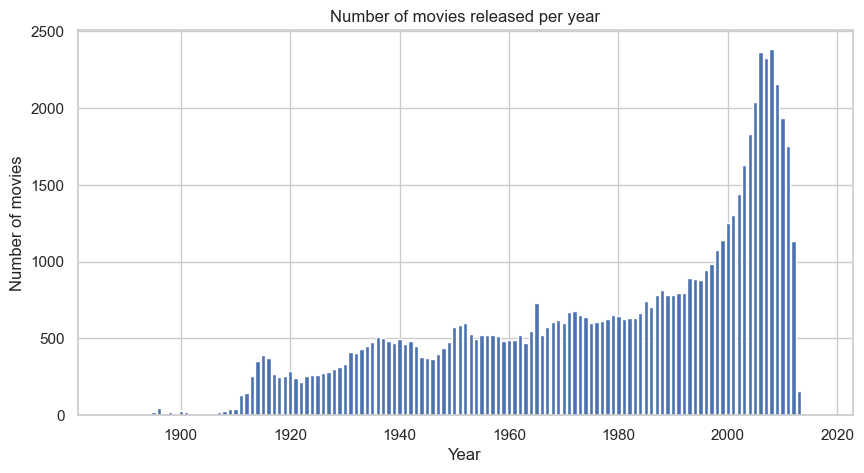

In [1859]:
# we want to plot the number of movies released per year
# we group by year and count the number of movies
yearly_movies = movies.groupby(movies['release_date'].dt.year)['release_date'].count().reset_index(name='count')


# plot the number of movies per year
plt.figure(figsize=(10,5))
plt.bar(yearly_movies['release_date'],yearly_movies['count'])
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies released per year')
plt.show()

In [1860]:
# we want to know how many movies were released before and after the year 2001, since this is the year of the twin towers attack
count_before2001 = yearly_movies[yearly_movies['release_date']<2001]['count'].sum()
count_after2001 = yearly_movies[yearly_movies['release_date']>=2001]['count'].sum()
print(f'Movies before the year 2001 are {count_before2001}')
print(f'Movies after the year 2001 are {count_after2001}')
print(f'The ratio of movies after the year 2001 is {count_after2001/(count_after2001+ count_before2001):.2}')  

Movies before the year 2001 are 49056
Movies after the year 2001 are 22488
The ratio of movies after the year 2001 is 0.31


The twin tower event has a relevant amount of films before (arounf 69%) and after (31%). This is a first sign that we can work analysing it through movies. 

Now, to really study arab actors, we read the actors df and work on the ethnicities.

# Ethnicity analysis

First of all, it is interesting to understand the ethnicity distribution of actors in the movies.

In [1861]:
# Read the character.metadata.tsv file
col_names = ['wikiID','freeID','release_date','character_name','birth','gender','height','ethnicity_code', 'actor_name', 'age_at_release', 'freeID_character_actor_map', 'freeID_character', 'freeID_actor']
characters= pd.read_csv(open(folder_std + "/character.metadata.tsv",encoding='utf-8'), delimiter="\t", names=col_names)

characters.head()

,wikiID,freeID,release_date,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We merge movies and character dataframes by using the freeID and wikiID, (identifiers for movies) as keys.

In [1862]:
# Merge the two dataframes on the wikiID and freeID
movies_characters = pd.merge(movies, characters, on=['freeID', 'wikiID'], how='inner', suffixes=('', '_y'))

# We drop the duplicate columns
movies_characters=movies_characters.drop(['release_date_y'], axis=1)
movies_characters.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [1863]:
# print the number of Actor ethnicities (Freebase ID)
eth_num = movies_characters['ethnicity_code'].unique().shape[0]
print(f'There are {eth_num} different ethnicities')


There are 480 different ethnicities


How to decode the Freebase ID to a precise ethnicity? We used a query command to the freebase API and got a database to work on.

In [1864]:
# read the csv file where we decode the ethnicities ID
ethnicity_decode = pd.read_csv(folder_add + "/ethnicity.csv",sep=',')
ethnicity_decode.columns= ['ethnicity_code', 'ethnicity_name']
ethnicity_decode.head()

,ethnicity_code,ethnicity_name
0,/m/07s8n27,Makonde people
1,/m/02k1vf,Powhatan
2,/m/0630vt,Apalachee people
3,/m/038cy,Germanic peoples
4,/m/03gq7tt,Hän people


In [1865]:
# merging the two dataframes
movies_characters_eth= pd.merge(movies_characters, ethnicity_decode, how='left', left_on=['ethnicity_code'], right_on=['ethnicity_code'])
movies_characters_eth.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN


Did the ethnicity_decode work for all the freeID?

In [1866]:
# filter the movies that have an eyhnicity_code but not the ethnicity_name
not_filtered= movies_characters_eth[movies_characters_eth['ethnicity_code'].notna() * movies_characters_eth['ethnicity_name'].isna()].copy()
print(f'characters not decoded: {not_filtered.shape[0]}')
print(f'portion of characters not decoded: {not_filtered.shape[0]/movies_characters_eth.shape[0]:.2}')

eth_not_decoded=not_filtered['ethnicity_code'].unique().shape[0]

eth_not_decoded_portion= eth_not_decoded/ movies_characters_eth['ethnicity_code'].unique().shape[0]
not_filtered['ethnicity_code'].unique().shape[0]

print(f'ethnicities not decoded {eth_not_decoded}')
print(f'portion of ethnicities not decoded {eth_not_decoded_portion:.2}')

characters not decoded: 50587
portion of characters not decoded: 0.11
ethnicities not decoded 158
portion of ethnicities not decoded 0.33


A good portion of ethnicity codes is not decoded into ethnicity names (33%). However, it is visible that these ethnicities appear rarely in the dataset, as only 11% of characters with ethnicity code do not present a correspondant ethnicity name.

We want to find the distribution of ethnicities in the dataset. 

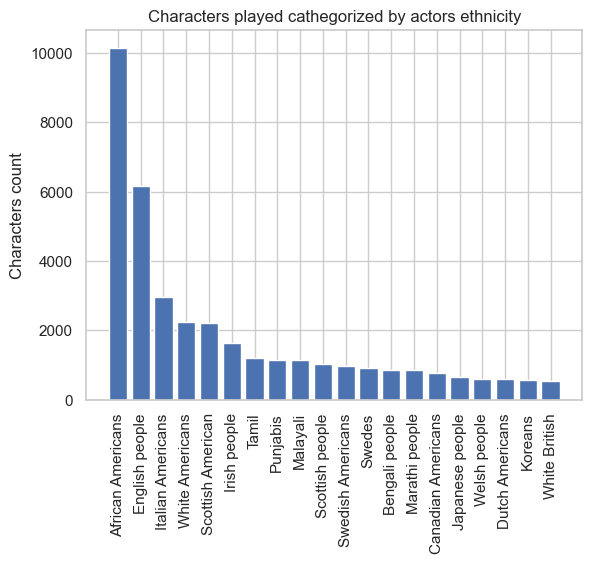

In [1867]:
ethnicity_count = movies_characters_eth.groupby(movies_characters_eth['ethnicity_name'])['ethnicity_name'].count().reset_index(name = 'count')

ethnicity_count = ethnicity_count.sort_values(by='count',ascending=False)
plt.bar(ethnicity_count['ethnicity_name'].iloc[:20],ethnicity_count['count'].iloc[:20])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Characters played cathegorized by actors ethnicity')
plt.show()

In [1868]:
print('In total, there are {} ethnicities of which we know the name.'.format(ethnicity_count['ethnicity_name'].shape[0]))

In total, there are 320 ethnicities of which we know the name.


To get the arabic ethnicities, we asked AI to identify ethnicities inside the list that can be considered of arabic culture. It is important to state that the arab ethnicities are really diverse and that generally anti-arab stereotypes are also linked to people of non-arab countries, but muslim. This is taken into consideration adding some ethnicities from Asia like Pakistan and Bengali.

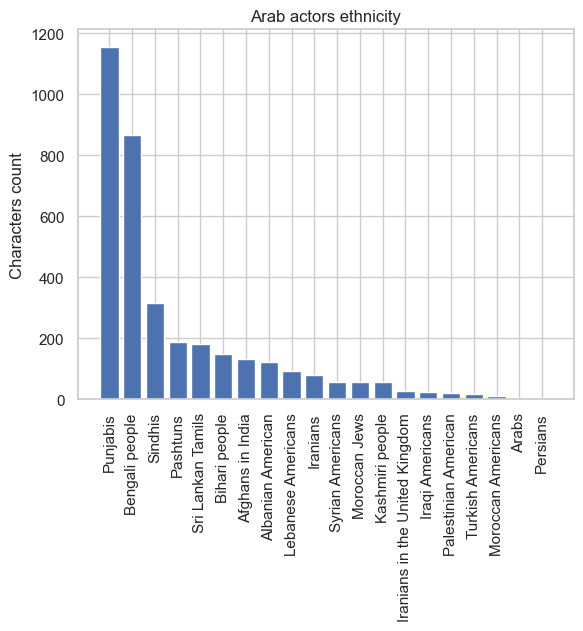

Arabic ethnicities are 20


In [1869]:
# unique ethnicities
eth_unique=ethnicity_count['ethnicity_name'].unique()

# Commonly associated arab ethnicities. we used Chat GPT results
arab_ethnicities = ['Punjabis', 'Bengali people', 'Pashtuns', 'Sri Lankan Tamils', 'Bihari people', 'Sindhis', 'Kashmiri people', 'Afghans in India', 'Iranians', 'Albanian American', 'Syrian Americans', 'Moroccan Jews', 'Kurdish', 'Iraqi Americans', 'Turkish Americans', 'Lebanese Americans', 'Iranians in the United Kingdom', 'Palestinian American', 'Moroccan Americans', 'Egyptian Americans', 'Libyan Americans', 'Algerian Americans', 'Tunisian Americans', 'Yemeni Americans', 'Saudi Americans', 'Omani Americans', 'Emirati Americans', 'Qatari Americans', 'Kuwaiti Americans', 'Bahraini Americans', 'Jordanian Americans', 'Palestinians', 'Rohingya people', 'Malays', 'Indonesians', 'Bangladeshis', 'Pakistanis', 'Turks', 'Persians', 'Arabs']
# manually deleted: 'Gujarati peole'
# dubious about: 'Punjabis'

# Filter ethnicities corresponding to arab people
arab_ethnicities_subset = list(np.intersect1d(eth_unique, arab_ethnicities))

# Select only the ethnicity name of eth_unique in the arab_ethnicities_subset
arab_count = ethnicity_count[ethnicity_count['ethnicity_name'].isin(arab_ethnicities)]
arab_count=arab_count.sort_values(by='count', ascending=False)
plt.bar(arab_count['ethnicity_name'],arab_count['count'])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Arab actors ethnicity')
plt.show()

# Number of Arabic ethnicities
print('Arabic ethnicities are {}'.format(len(arab_ethnicities_subset), arab_ethnicities_subset))

In [1870]:
# proportion of arab characters
print(f"From the ethnicities provided, {arab_count['count'].sum()} characters over the years are classified as arab characters.")
print(f'Proportion of arab characters w.r.t. all characters is {arab_count["count"].sum()*100/ethnicity_count["count"].sum():.3}%')

From the ethnicities provided, 3551 characters over the years are classified as arab characters.
Proportion of arab characters w.r.t. all characters is 6.4%


# Arab names analysis

The main focus of our project is the character ethnicity, not the actor ethnicity, even though they are generally related. To do so, we analyse a list of commonly arab names and we check their presence in the character name column. 

By starting to filter the Dataframe for characters with a name within the list, we then filter for movies of United States and European production. Finally, we check if these character names are present in the plot, to asses the feasibility of the sentiment analysis, to be done in the following phases of the project.

A list of arab names (male and female) is retrieved from Wikipedia and is contained in the file arab_names.txt. This list is enriched by adding common AI generated adjectives which refer to the arab and muslim culture. This is done because the column characters_name uses a general description of the character when not a primary role. Also, some names where manually deleted as ambiguous and possibly having a different cultural origin.

In [1871]:
# Read the file
with open(folder_add+'/arab_names.txt', 'r') as file:
    names = file.readlines()

# Clean and format the names (with list comprehension)
arab_names = [' '.join(name.strip().split(' ')[0:-1]) if '(name)' in name else ' '.join(name.strip().split(' ')[0:-2]) if '(given name)' in name else name.strip() for name in names]

arab_names = [str(item).lower() for item in arab_names]

In [1872]:
# Function to determine if the character name is an arab name
def filter_arab_names(name):
    name = str(name).lower()
    for n in arab_names:
        if n in name.split():
            return True
        
    return False

The dataframe is filtered for what are designated as "arabic characters".

This line of code is the longest of the notebook to be executed.

In [1873]:
movies_characters_ar = movies_characters_eth[movies_characters_eth['character_name'].apply(filter_arab_names)]
movies_characters_ar.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
202,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],"[Family Film, Comedy]",Rahim,1923-11-11,M,NaN,/m/0dryh9k,Johnny Walker,60.0,/m/02vd0_r,/m/0h6_rbb,/m/07l4kn,NaN
564,4300418,/m/0bvx7h,The Hero: Love Story of a Spy,2003-04-11,NaN,182.0,[Hindi Language],[India],"[Thriller, Action Thrillers, Adventure, World ...",I.S.I Chief Ishak Khan,1932-06-22,M,NaN,/m/0dryh9k,Amrish Puri,70.0,/m/0k5bsd,/m/0h73qj8,/m/01k6nm,NaN


In [1874]:
# Examples of character names classified as arab names
movies_characters_ar['character_name']

202                        Rahim
564       I.S.I Chief Ishak Khan
798                     Amal Raj
987                Ali La Pointe
991                       Halima
                   ...          
447804             Jamal Hassani
448077                     Nader
449075          Rev. Fred Sultan
449653                Bobby Nair
450406              Prince Akeem
Name: character_name, Length: 1501, dtype: object

In [1875]:
print('The number of characters with a name classified as arab is {}.'.format(movies_characters_ar['character_name'].shape[0]))

The number of characters with a name classified as arab is 1501.


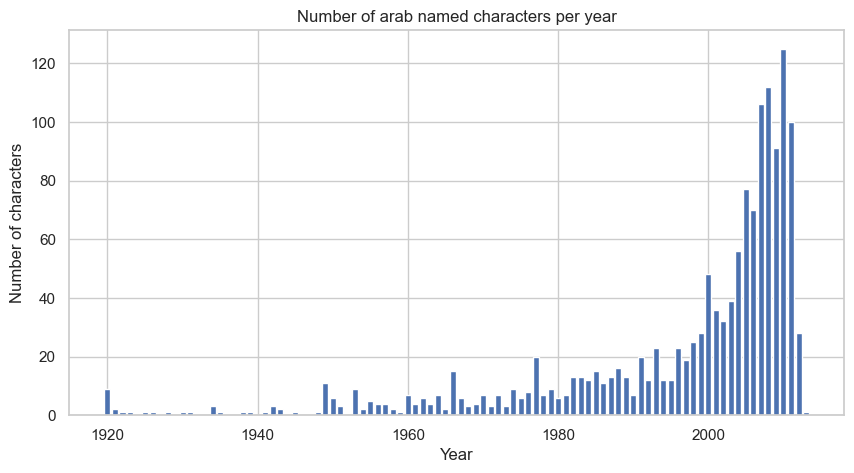

In [1876]:
# How many movies with arab people per year
yearly_characters = movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
yearly_characters['arabs_fraction'] = yearly_characters['arabs_count'] / movies_characters.groupby(movies_characters['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_fraction')['arabs_fraction']
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'])

plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year')
plt.show()

In [1877]:
# classifying the movies as before and after 2001
count_before2001 = yearly_characters[yearly_characters['release_date']<=2001]['arabs_count'].sum()
count_after2001 = yearly_characters[yearly_characters['release_date']>2001]['arabs_count'].sum()
print(f'Arab named characters before the year 2001 are {count_before2001}')
print(f'Arab named characters after the year 2001 are {count_after2001}')
print('The total is less because some movies do not have the release date (NaN).')

Arab named characters before the year 2001 are 600
Arab named characters after the year 2001 are 837
The total is less because some movies do not have the release date (NaN).


Now, we want to look at the Arab characters distribution per country where the film is produced. mainly, we look at Europe, USA and India.

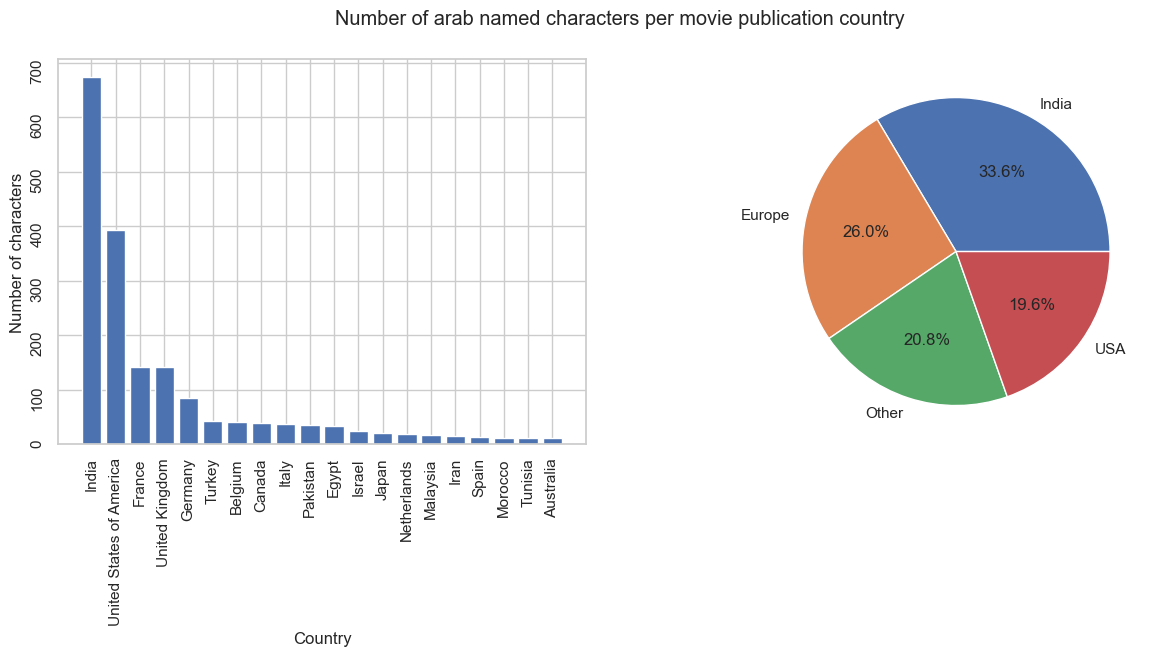

In [1878]:
# Arab characters per country
exploded = movies_characters_ar.explode('countries')
country_counts = exploded['countries'].value_counts()

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(country_counts.index[:20],country_counts.values[:20])
ax[0].tick_params(labelrotation=90)
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Number of characters')
fig.suptitle('Number of arab named characters per movie publication country')

# Group USA, European countries and india all together, and classify the rest as 'other'
# European countries list. This are countries that are entirely in the European continent
# Source: https://en.wikipedia.org/wiki/Europe

eu_countries = ['France','Germany','Italy','Spain','United Kingdom', 'Sweden', 'Netherlands', 'Denmark', 'Finland', 'Belgium', 'Greece', 'Austria', 'Switzerland', 'Norway', 'Ireland', 'Portugal', 'Luxembourg', 'Iceland', 'Czech Republic', 'Hungary', 'Poland', 'Romania', 'Bulgaria', 'Slovakia', 'Estonia', 'Latvia', 'Lithuania', 'Croatia', 'Slovenia', 'Cyprus', 'Malta']

exploded['countries'] = exploded['countries'].apply(lambda x: 'USA' if x=='United States of America' else 'Europe' if x in eu_countries else 'India' if x=='India' else 'Other')
country_grouped_counts = exploded['countries'].value_counts()

ax[1].pie(country_grouped_counts.values,labels=country_grouped_counts.index,autopct='%1.1f%%')
plt.show()


It is visible from the histogram above how the majority of arab characters are present in Indian movies. This is because arab/muslim culture is very influent in this country, for the vicinity to Arab countries.  

European countries can be considered under the United States cultural influence. Thus, it makes sense to add them into the analysis, to extend the number of characters and have a more statistically relevant sentiment analysis.

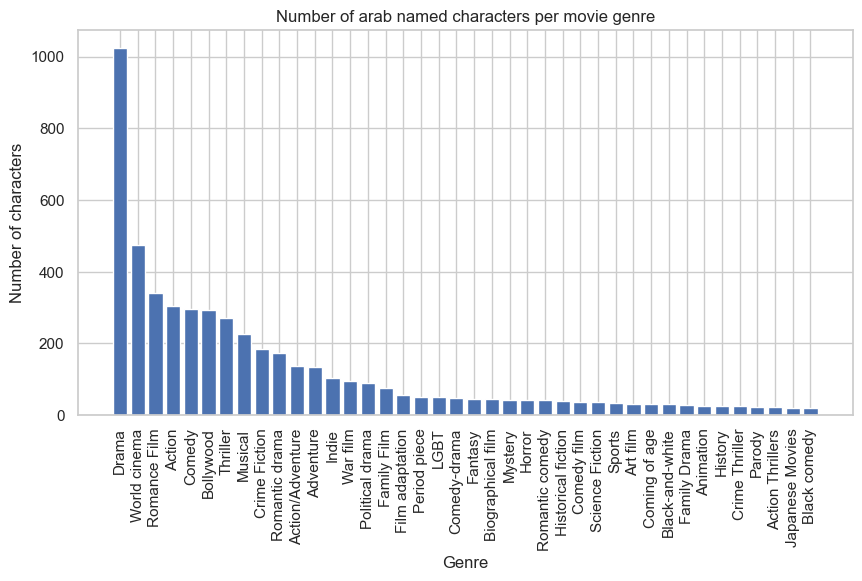

In [1879]:
# Arab characters per genre
plt.figure(figsize=(10,5))
exploded = movies_characters_ar.explode('genres')
genre_counts = exploded['genres'].value_counts()
genre_counts = genre_counts.sort_values(ascending=False)
plt.bar(genre_counts.index[:40],genre_counts.values[:40])
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per movie genre')
plt.show()

It is important to note that the graphs counts, both for country and genre cathegorizations, do not add up to the total number of arab characters in the Dataframe but to a larger number. This happens because some charecters are counted multiple times, as the movie they are in is classified with more than one genre or is published in more than one country. However, for our analysis it is important to have a number for the totality of each cathegories, making this graph meaningful as initial considerations before the actual project. 

As already stated, we are mainly interested in movies from USA, Canada and Europe.

In [1880]:
# Filter arab movie characters from the western countries
western_countries = ['United States of America','Canada']+eu_countries

# For each character, we filter for movies pubblished in western countries
mask_characters_western = movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)
movies_characters_ar_western = movies_characters_ar[mask_characters_western]
mask_characters_ar_western = movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)
movies_characters_ar_western = movies_characters_ar[mask_characters_ar_western]
print('The total number of characters from western countries is {}.'.format(movies_characters_ar_western.shape[0]))

The total number of characters from western countries is 678.


In [1881]:
# Arab movie characters from western countries count before and after 2001
yearly_characters_western = movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
arab_western_before = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year<=2001].shape[0]
arab_western_after = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year>2001].shape[0]
print('The total number of characters from western countries before 2001 is {}.'.format(arab_western_before))
print('The total number of characters from western countries after 2001 is {}.'.format(arab_western_after))

The total number of characters from western countries before 2001 is 255.
The total number of characters from western countries after 2001 is 396.


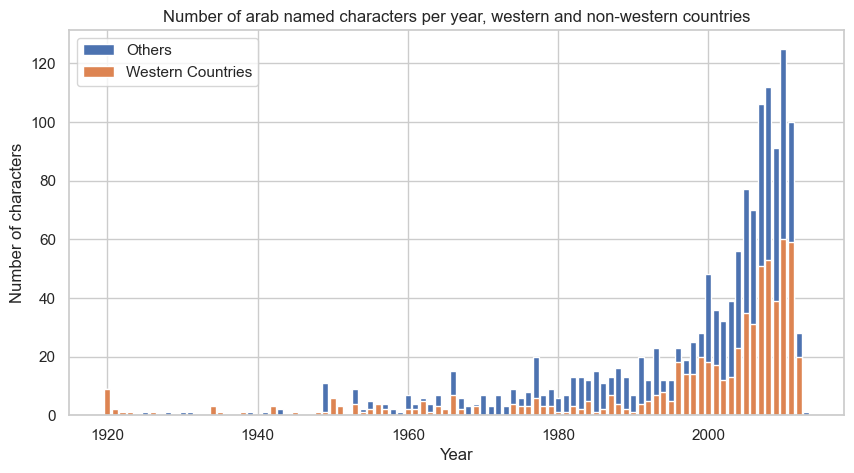

In [1882]:
# Classify movies per year divided into western and non-western countries
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'],label='Others')
plt.bar(yearly_characters_western['release_date'],yearly_characters_western['arabs_count'],label='Western Countries')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year, western and non-western countries')
plt.show()

In [1883]:
# view the value in the year 1980

yearly_characters.loc[yearly_characters['release_date'].isin(range(1965,1990))]

,release_date,arabs_count,arabs_fraction
33,1965.0,2,0.009709
34,1966.0,15,0.075000
35,1967.0,6,0.027907
36,1968.0,3,0.012397
37,1969.0,4,0.014493
38,1970.0,7,0.018277
39,1971.0,3,0.004823
40,1972.0,7,0.013208
41,1973.0,3,0.006289
42,1974.0,9,0.017578


## Arab characters role in war and crime movies.

Now, we want to get a first sight on the arab presence in the filmography. We are going to evaluate the genre which they play, to get an idea if 9/11 influences how many arab characters play a role linked to crime and violence. 
We select the genres Crime Fiction and War films as the ones that treat crime and violence as a theme. 

In [1884]:
# First of all, we drop the rows without a release date
movies_characters = movies_characters[movies_characters['release_date'].notna()]
movies_characters_ar = movies_characters_ar[movies_characters_ar['release_date'].notna()]

In [1885]:
# Also, we drop the rows without a genre
movies_characters['no_genres'] = movies_characters['genres'].apply(lambda x: 1 if x==[] else 0)
movies_characters_ar['no_genres'] = movies_characters_ar['genres'].apply(lambda x: 1 if x==[] else 0)

# Show the number of characters in a film without a genre
print('The number of movies without a genre is {}.'.format(movies_characters[movies_characters['no_genres']==1].shape[0]))
print('The number of movies without a genre is {}.'.format(movies_characters_ar[movies_characters_ar['no_genres']==1].shape[0]))
# yearly_characters = yearly_characters.merge(movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['no_genres'].sum().reset_index(name='ar_no_genres'), on='release_date', how='left')

# Drop the rows without a genre
movies_characters = movies_characters[movies_characters['no_genres']==0]
movies_characters_ar = movies_characters_ar[movies_characters_ar['no_genres']==0]


The number of movies without a genre is 3518.
The number of movies without a genre is 5.


In [1886]:
# For every arab character, we indicate if they play a movie of the Crime, War Genre or not
Selected_genres = ['Crime Fiction' , 'War film'] 
# Add the column cri_and_vio_genres for the general dataframe and the specifical for arabs
movies_characters.loc[:, 'cri_and_vio_genres'] = movies_characters['genres'].apply(lambda x: list(set(x) & set(Selected_genres)) != []).astype(int) 
movies_characters_ar.loc[:, 'cri_and_vio_genres'] = movies_characters_ar['genres'].apply(lambda x: list(set(x) & set(Selected_genres)) != []).astype(int)
movies_characters_ar.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,...,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name,no_genres,cri_and_vio_genres
202,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],"[Family Film, Comedy]",Rahim,...,NaN,/m/0dryh9k,Johnny Walker,60.0,/m/02vd0_r,/m/0h6_rbb,/m/07l4kn,NaN,0,0
564,4300418,/m/0bvx7h,The Hero: Love Story of a Spy,2003-04-11,NaN,182.0,[Hindi Language],[India],"[Thriller, Action Thrillers, Adventure, World ...",I.S.I Chief Ishak Khan,...,NaN,/m/0dryh9k,Amrish Puri,70.0,/m/0k5bsd,/m/0h73qj8,/m/01k6nm,NaN,0,0


Now, we need to appropriately select the range of years to take in consideration for further analysis. In particular, we want to measure the genre partecipation feature for arab characters before and after 9/11. We define a starting year in the analysis 
- to limit the effect of other events in time 
- to start from years where arabs participation in movies was relevant and war and crime films were present in cinema panorama

In [1887]:
# see the evolution of 'cry_and_vio_genres' over the years
cri_and_vio= movies_characters.groupby(movies_characters['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')
cri_and_vio_ar = movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')

Text(0.5, 1.0, 'Number of arab named characters per year in w&c movies')

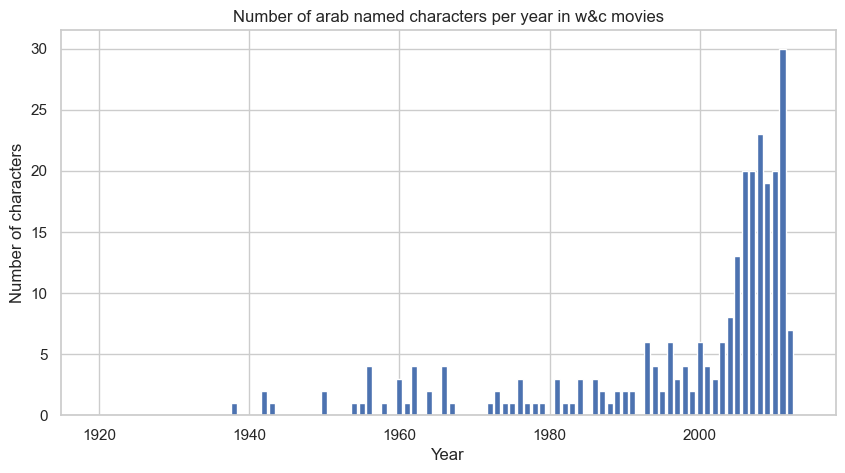

In [1888]:
#plot the characters with crime and war genre per year
plt.figure(figsize=(10,5))
plt.bar(cri_and_vio_ar['release_date'],cri_and_vio_ar['count'],label='arabs')
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year in w&c movies')

As visible from the above bar plot, the presence of arab charactacters in w and crime movies is not consistent before 1972. Therefore, we will filter the data from this year afterwards. In addition, we can see from this plot and from overall movies per year trend, that there is a drop of reported films, and therefore characters, after 2012. Thus, we decide to eliminate movies after this year for the analysis, as they could give a biased representation.

In [1889]:
# Filter for the movies between 1972 and 2012
limit_years = [1972, 2013]
movies_characters = movies_characters[movies_characters['release_date'].dt.year.isin(range(limit_years[0],limit_years[1]))]
movies_characters_ar = movies_characters_ar[movies_characters_ar['release_date'].dt.year.isin(range(limit_years[0],limit_years[1]))]
cri_and_vio = cri_and_vio[cri_and_vio['release_date'].isin(range(limit_years[0],limit_years[1]))]
cri_and_vio_ar = cri_and_vio_ar[cri_and_vio_ar['release_date'].isin(range(limit_years[0],limit_years[1]))]

We look at the percentge of characters that play a role in a W&C movies over the years. Also, we consider specifically the arab characters, dividing the arab characters in W&C movies over the total arab characters number, per year. This is done to understand if arabs are casted more in W&C genres respect to the overall behaviour and if there is a trend in their partecipation.

In the arab case we do not divide by the total number of characters per year to avoid the possible confounder of an increase of arab characters in general, that could bring to a higher value of this indicator whithout any other reason linked to the 2001 event.

In [1892]:
# Calculate the ratio of characters in the movies with crime and war genre
cri_and_vio = cri_and_vio.merge(movies_characters.groupby(movies_characters['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean'), on='release_date', how='left')
# Calculate the ratio of arab characters in the movies with crime and war genre
cri_and_vio_ar = cri_and_vio_ar.merge( movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean'), on='release_date', how='left')
# Statistic for the arab count over the total count, not used in the report
cri_and_vio_ar['count_ar_vs_count_gen'] = cri_and_vio_ar['count']/cri_and_vio['count']

cri_and_vio.head()

,release_date,count,mean
0,1972,595,0.159774
1,1973,793,0.230993
2,1974,647,0.184278
3,1975,514,0.179469
4,1976,732,0.230116


Plot with the percentage of characters that have a role in war and crime movies, both for overall characters and for arabs.

In [1893]:
# We define a bootstrapping function to compute the confidence interval, we use a 95% c.i.
# For every iteration (iter) we take a sample as big as the input pandas series (vec), sorting with replacement. 
# we compute the fraction of characters in W&C genres and we return the 2.5% and 97.5% percentiles of the distribution.
def bootstrapping(iter, vec):
    c=np.zeros(iter)
    for k in range(iter):
        samp=vec.sample(frac=1 ,replace=True)
        c[k]=samp.mean()
    c=np.array(c)
    return [ np.percentile(c, 2.5),  np.percentile(c, 97.5)]

In [1894]:
# Confidence interval computation for the yearly trend of arabs partecipating in W&C movies
conf_int_mc = pd.DataFrame(columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])
for year in range(limit_years[0],limit_years[1]):
    # We compute the confidence interval for the fraction of missing data for every year
    low, up = bootstrapping(1000, movies_characters[movies_characters['release_date'].dt.year==year]['cri_and_vio_genres'])
    low_ar, up_ar = bootstrapping(1000, movies_characters_ar[movies_characters_ar['release_date'].dt.year==year]['cri_and_vio_genres'])

    conf_int_mc = pd.concat([conf_int_mc, pd.DataFrame([[int(year), low, up, low_ar, up_ar]], columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])], ignore_index=True) 

In [1895]:
# convert the release date to int
conf_int_mc['release_date'] = conf_int_mc['release_date'].astype(int)

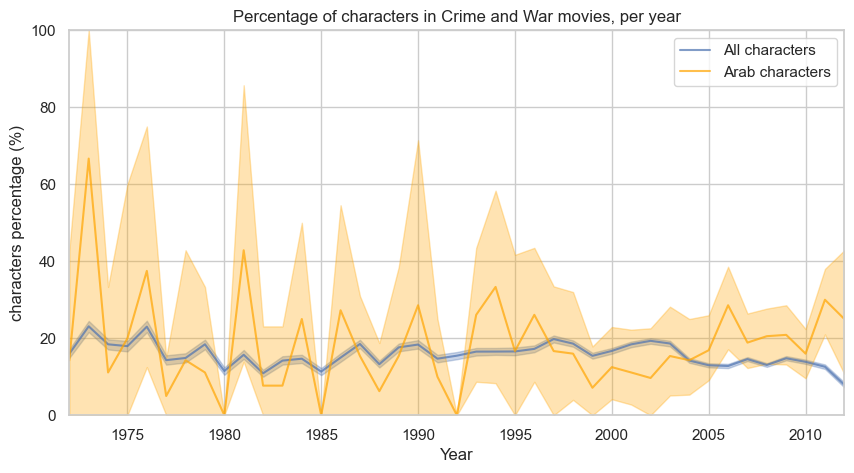

In [2037]:
# plot the yearly trend of characters with roles in crime and war movies, all characters and arab characters

plt.figure(figsize=(10,5))
plt.fill_between(conf_int_mc['release_date'], conf_int_mc['low']*100, conf_int_mc['up']*100, alpha=0.3, color='b')
plt.plot(cri_and_vio['release_date'],cri_and_vio['mean']*100, label='All characters', alpha=0.7, color='b')

plt.fill_between(conf_int_mc['release_date'], conf_int_mc['low_ar']*100, conf_int_mc['up_ar']*100, alpha=0.3, color='orange')
plt.plot(cri_and_vio_ar['release_date'],cri_and_vio_ar['mean']*100, label='Arab characters', alpha=0.7, color='orange')

plt.legend()
plt.xlabel('Year')
plt.ylabel('characters percentage (%)')
plt.xlim(1972, 2012)
plt.ylim(0,100)
plt.title('Percentage of characters in Crime and War movies, per year')
plt.show()

- Considering all the characters (blue bars), We can see that there is no clear trend. After 2003 the value seems eventually to decrease, that means a decresing partecipation for characters in W&C movies.

- Arabs (red bars) show a lot of fluctuations during the years, evidently during the last century. This is due to the small partecipation in W&C (less than 5 per year before 2003), generating less reliable percentages. After 2004 arab characters seems to play a higher fraction of these genre films than the overall characters in terms of mean values. Still the uncertainty given by bootstrapping shows that this can be stated only for years 2006, 2011 and 2012, where the confidence intervals do not intersect.

We can be more precise on this analysis looking at the feature before and after 2001. This grouping is done to avoid the problem of sparsity of data for arabs, specially doring the last century movies, that leads to high uncertainty. We will use an observational study scheme, with the treatment as the publication after 2001 and the outcome as the fraction of arab characters in W&C movies. First of all, we want to understand if the "all characters trend" is really negative for war and crime movies, giving a first prove that this is not the reason for the possible positive correlalation for arabs.

In [1899]:
# OVERALL TREND, all characters
# Create a new column for the treatment (after 2001)
movies_characters.loc[:, 'treatment'] = movies_characters['release_date'].apply(lambda x: 1 if x.year > 2001 else 0)

# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001]
treated = movies_characters[movies_characters['treatment']==1]
control = movies_characters[movies_characters['treatment']==0]

print('the treated population is {}.' .format(treated.shape[0]))
print('the control population is {}.' .format(control.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control['cri_and_vio_genres'].mean(), 3), round(control['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated['cri_and_vio_genres'].mean(), 3), round(treated['cri_and_vio_genres'].std(), 3)))

the treated population is 151159.
the control population is 156244.
The mean before 2001 is 0.166 with a standard deviation of 0.372.
The mean after 2001 is 0.142 with a standard deviation of 0.349.


In [1900]:
# set the logistic regression model
model_1 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters)
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     335.5
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           6.73e-75
Time:                        19:51:44   Log-Likelihood:            -1.2260e+05
No. Observations:              307403   AIC:                         2.452e+05
Df Residuals:                  307401   BIC:                         2.452e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1655      0.00

From the linear regression model we see a slightly negative correlation, still significative, betweeen the partecipation in war and crime films and the year of pubblication, confirming the qualitative obsevation on the yearly trend. Perticularly, there is negative correlation between producing the film after 2001 and characters in war and crime genre films. Is it the same for arabs?

In [1901]:
# ARAB CHARACTERS TREND
# Create a new column for the treatment (after 2001)
movies_characters_ar.loc[:, 'treatment'] = movies_characters_ar['release_date'].apply(lambda x: 1 if x.year > 2001 else 0)

# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001]
treated = movies_characters_ar[movies_characters_ar['treatment']==1]
control = movies_characters_ar[movies_characters_ar['treatment']==0]

print('the treated population is {}.' .format(treated.shape[0]))
print('the control population is {}.' .format(control.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control['cri_and_vio_genres'].mean(), 3), round(control['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated['cri_and_vio_genres'].mean(), 3), round(treated['cri_and_vio_genres'].std(), 3)))


the treated population is 835.
the control population is 451.
The mean before 2001 is 0.151 with a standard deviation of 0.358.
The mean after 2001 is 0.202 with a standard deviation of 0.402.


In [1902]:
# set the logistic regression model
model_2 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters_ar)
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.203
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0227
Time:                        19:51:44   Log-Likelihood:                -603.71
No. Observations:                1286   AIC:                             1211.
Df Residuals:                    1284   BIC:                             1222.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1508      0.01

Differently from the general analysis, the arab characters show higher partecipation in violent films after 2001, from 15.1% to 20.2%. The logistic regression confirms this result with a positive coefficient for the treatment variable of 5.16%, the percentage increase, and a p-value= 2.3% < 5%, meaning that the result is significative.
We can therefore state that whereas the W&C characters fraction decrase in time, this is not the same for arabs, for which this percentage increases.
Now, we want to analyse this correlation to understand if there is a causal link between the treatment and the outcome, through an observational study.


## "All world" observational study

As mentioned, we are investigating, for arab characters, the causal link between 'partecipation of a film released after 2001' and 'movie belongs to a w&c genre'. 
First of all, we need to discuss the possible confounders of the causal analysis. We treat the following features
- geographical zone of the movie pubblication
    - effect on the treatment: cinema industy can be more or less active in a country depending on cultural and economic effect that may change during the years. Es: boom of the indian industry after 2000
    - effect on the outcome: different countries have different cultures, so different incidence on a certain genre. es: a c&w film with arab caracters could be pubblished more probably in the US
- sex of the actor: 
    - effect on the treatment: arab females could be obstacled to be actress for religious rules that were stricter in the past, so there could be less female arab characters in the past 
    - effect on the outcome: male characters could be used more frequently in w&c films
- age of the actor at release 
    - effect on the treatment: during the film history it is possible that the presence of young actors was obtacled by certain legal/cultural rules
    - effect on the outcome: young characters and therefore actors could have a role more frequently in w&c films


First of all, we create onehot columns for the categorical covariates.

In [1903]:
# create one hot column for each gender
pd.get_dummies(movies_characters_ar['gender'])

dummies=pd.get_dummies(movies_characters_ar['gender']).astype(int).add_suffix('_onehot')
movies_characters_ar= pd.concat([movies_characters_ar, dummies] , axis=1)

In [1904]:
# Get dummies for the countries
pd.get_dummies(movies_characters_ar['countries'].explode()).astype(int).groupby(level=0).sum().shape


(1286, 68)

There are 70 countries, so 70 onehot columns for this confounder. It could be better to group the country by the world regions according to the United Nations (https://ourworldindata.org/world-region-map-definitions). These depicts precise zones where the cultural influence is the same. The region is saved in the 'continent' column.


In [1905]:
# Add the world region database, by the World Bank, to classify the countries
country_regions = pd.read_csv(folder_add + '/world-regions-sdg-united-nations.csv',sep=',')
columns=['Country', 'Code', 'Year', 'Region']
country_regions.columns=columns
# add list of countries that are not in the world bank dataset
# we add the United States of America that were present only as United States.
country_regions.loc[country_regions.shape[0]]=['United States of America','USA',2020,'Europe and Northern America']

# also, we notice that the country 'Djibouti' is the only country classified as 'Middle East and North Africa' so we change it to 'Northern Africa and Western Asia
country_regions.loc[country_regions['Country']=='Djibouti','Region']='Northern Africa and Western Asia'

country_regions.head()



,Country,Code,Year,Region
0,Afghanistan,AFG,2021,Central and Southern Asia
1,Aland Islands,ALA,2021,Europe and Northern America
2,Albania,ALB,2021,Europe and Northern America
3,Algeria,DZA,2021,Northern Africa and Western Asia
4,American Samoa,ASM,2021,Oceania


In [1906]:
# Function to classify the countries in the world bank dataset
def continent(country_list):
    continent = set()
    missing_country = set()
    for country in country_list:
        if country in country_regions['Country'].values:
            continent.add(country_regions[country_regions['Country']==country]['Region'].values[0])
        else:
            continent.add('Other')
            missing_country.add(country)
    return (list(continent), list(missing_country))
continent(['gig'])[0]

                       


['Other']

In [1907]:
# Check the world regions
country_regions['Region'].unique()

array(['Central and Southern Asia', 'Europe and Northern America',
       'Northern Africa and Western Asia', 'Oceania',
       'Sub-Saharan Africa', 'Latin America and Caribbean',
       'Eastern and South-Eastern Asia'], dtype=object)

Some countries are not present in the database because they are not still existing, are not politically recognised or there is a spelling problem. We add them manually.

In [1908]:
# Create the continent column
missing_country = set()
movies_characters_ar['continent'] = movies_characters_ar['countries'].apply(lambda x: continent(x)[0])
missing_country = movies_characters_ar['countries'].apply(lambda x: continent(x)[1])
missing_country = [item for sublist in missing_country for item in sublist]
missing_country = set(missing_country)
print(missing_country)



{'Soviet Union', 'England', 'Malayalam Language', 'Taiwan', 'Kingdom of Great Britain', 'Slovak Republic', 'Palestinian territories', 'Czech Republic', 'Mandatory Palestine', 'West Germany', 'Republic of Macedonia'}


In [1909]:
# Add the missing countries to the world bank dataset 
missingcountry_dict = {'Country': ['Soviet Union',                'Republic of Macedonia',       'West Germany',                'Czech Republic',              'Malayalam Language',        'Slovak Republic',             'Kingdom of Great Britain',    'Mandatory Palestine',              'Taiwan',                         'England',                     'Palestinian territories'],
                        'Code': ['NaN']* 11, 
                        'Year': [2020]* 11, 
                        'Region': ['Europe and Northern America', 'Europe and Northern America', 'Europe and Northern America', 'Europe and Northern America', 'Central and Southern Asia', 'Europe and Northern America', 'Europe and Northern America', 'Northern Africa and Western Asia', 'Eastern and South-Eastern Asia', 'Europe and Northern America', 'Northern Africa and Western Asia']}
missingcountry_df = pd.DataFrame(missingcountry_dict)
country_regions = pd.concat([country_regions, missingcountry_df], axis=0)

# Recreate the continent column
movies_characters_ar['continent'] = movies_characters_ar['countries'].apply(lambda x: continent(x)[0])

In [1910]:
# Get dummies for the countries
dummies2=pd.get_dummies(movies_characters_ar['continent'].explode()).astype(int).groupby(level=0).sum().add_suffix('_onehot')
dummies2.columns = dummies2.columns.str.replace(' ', '_')
dummies2.columns = dummies2.columns.str.replace('-', '_')
dummies2.head()

,Central_and_Southern_Asia_onehot,Eastern_and_South_Eastern_Asia_onehot,Europe_and_Northern_America_onehot,Latin_America_and_Caribbean_onehot,Northern_Africa_and_Western_Asia_onehot,Oceania_onehot,Sub_Saharan_Africa_onehot
202,1,0,0,0,0,0,0
564,1,0,0,0,0,0,0
798,1,0,0,0,0,0,0
1459,0,0,0,0,1,0,0
1460,0,0,0,0,1,0,0


In [1911]:
# Add the world region dummies to the dataframe
movies_characters_ar= pd.concat([movies_characters_ar, dummies2] , axis=1)

Plot the confounders for the treatment and control groups

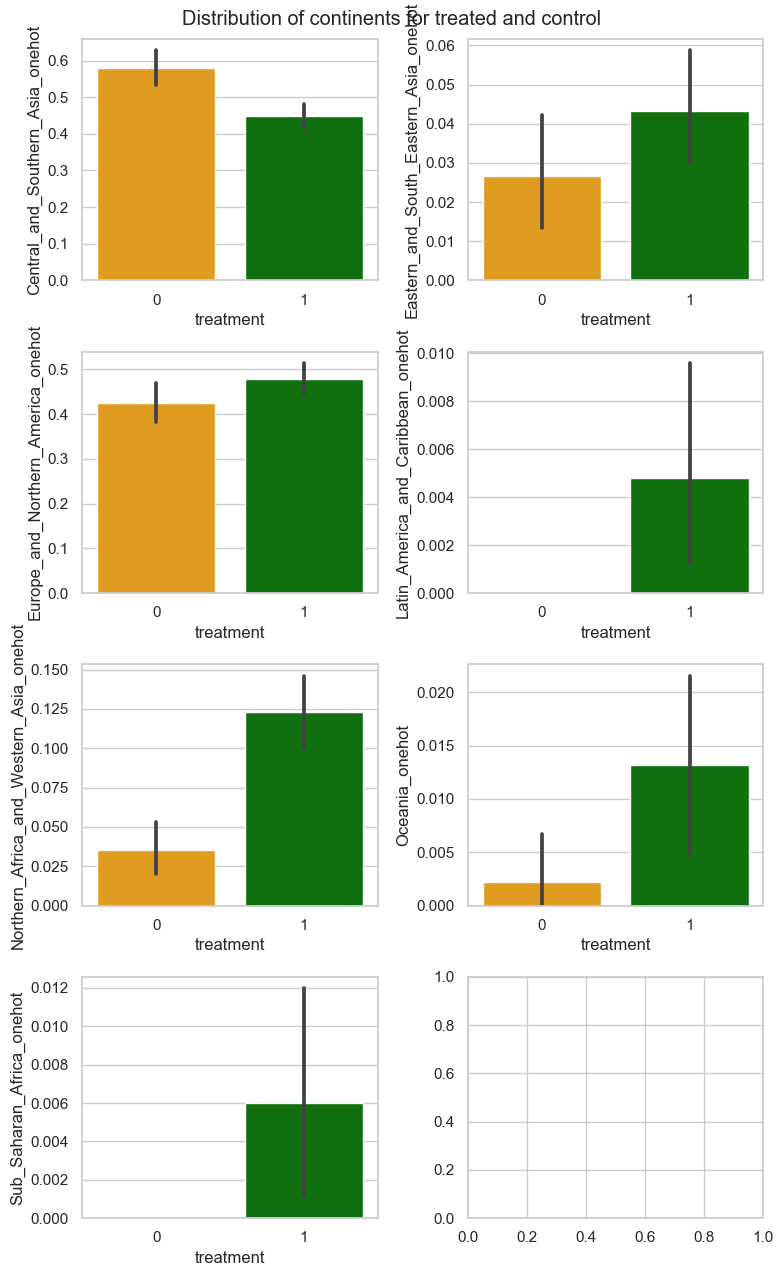

In [1912]:
# plot continent distribution for treated and control with subplots for each continent
fig, ax = plt.subplots(4, 2, figsize=(8, 13))
fig.suptitle('Distribution of continents for treated and control')
for i, continent in enumerate(dummies2.columns):
    sns.barplot(x='treatment', y=continent, data=movies_characters_ar[movies_characters_ar['treatment'].isin([0, 1])], palette=['orange', 'green'], ax=ax[i//2, i%2])
plt.tight_layout()
plt.show()

For the propensity score, we are not going to use the 'Sub Saharan Africa' and 'Latin America and Carribean'. They appear only in the treatment feature and also rarely, less than 0.6% in mean. It means that their presence in the treatment should not change significntly the results.

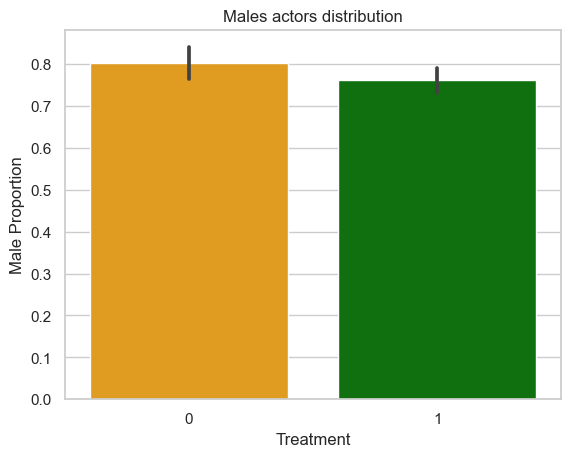

In [1913]:
# plot gender distribution for treated and control population
sns.barplot(x='treatment', y='M_onehot', data=movies_characters_ar[movies_characters_ar['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Males actors distribution')
plt.xlabel('Treatment')
plt.ylabel('Male Proportion')
plt.show()

Text(0, 0.5, 'Age')

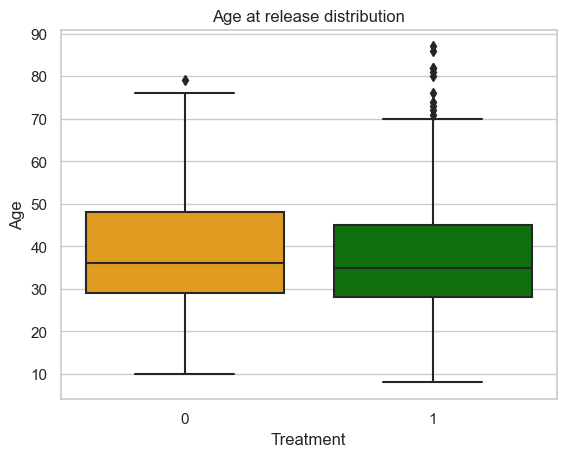

In [1914]:
# Plot for age distribution for treated and control population
sns.boxplot(x='treatment', y='age_at_release', data=movies_characters_ar[movies_characters_ar['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Age at release distribution')
plt.xlabel('Treatment')
plt.ylabel('Age')

Now, we standardise for the continuous variable. Then, we create a propensity score to balance the confounders in treatment and control. We use a logistic regression model.

In [1916]:
# standardise the age
movies_characters_ar['age_at_release'] = (movies_characters_ar['age_at_release'] - movies_characters_ar['age_at_release'].mean())/movies_characters_ar['age_at_release'].std()

mod = smf.logit(formula= 'treatment ~   age_at_release + C(M_onehot) + C(Central_and_Southern_Asia_onehot) + C(Eastern_and_South_Eastern_Asia_onehot) + C(Europe_and_Northern_America_onehot) + C(Northern_Africa_and_Western_Asia_onehot) + C(Oceania_onehot)', 
                 data= movies_characters_ar,
                 maxiter=1000)
res = mod.fit()

movies_characters_ar['Propensity_score'] = res.predict(movies_characters_ar)

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.662749
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  852
Model:                          Logit   Df Residuals:                      844
Method:                           MLE   Df Model:                            7
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                 0.01809
Time:                        19:51:47   Log-Likelihood:                -564.66
converged:                       True   LL-Null:                       -575.07
Covariance Type:            nonrobust   LLR p-value:                  0.004066
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                         

In [1917]:
# Propensity score statistics
movies_characters_ar['Propensity_score'].describe()

count    852.000000
mean       0.595070
std        0.074184
min        0.430957
25%        0.550752
50%        0.583896
75%        0.600547
max        0.895828
Name: Propensity_score, dtype: float64

Now, to balance the groups, we create a bipartite graph and add as weigh the similarity value based on the propensity score. We match control and treatment elements optimising for similarity.

In [1918]:
# Similarity function
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [1919]:
# Separate the treatment and control groups
treated = movies_characters_ar[movies_characters_ar['treatment'] == 1]
control = movies_characters_ar[movies_characters_ar['treatment'] == 0]

# Create an empty graph
G=nx.Graph()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treated.iterrows():
    for control_id, control_row in control.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [1920]:
# concatenate the tuple elements (couples) in a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_ar= movies_characters_ar.loc[matched]

In [1921]:
# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001
treated_bal = balanced_ar[balanced_ar['treatment']==1]
control_bal = balanced_ar[balanced_ar['treatment']==0]

print('the treated population is {}.' .format(treated_bal.shape[0]))
print('the control population is {}.' .format(control_bal.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control_bal['cri_and_vio_genres'].mean(), 3), round(control_bal['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated_bal['cri_and_vio_genres'].mean(), 3), round(treated_bal['cri_and_vio_genres'].std(), 3)))

the treated population is 345.
the control population is 345.
The mean before 2001 is 0.145 with a standard deviation of 0.353.
The mean after 2001 is 0.206 with a standard deviation of 0.405.


With the balanced treated and control groups, we can repeat the linear regression to check if there is still a significative correlation.

In [1922]:
# set the logistic regression model
model_3 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=balanced_ar)
result_3 = model_3.fit()
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.435
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0356
Time:                        19:54:56   Log-Likelihood:                -309.72
No. Observations:                 690   AIC:                             623.4
Df Residuals:                     688   BIC:                             632.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1449      0.02

After the balancing of the treated and control samples for the confounding features the linear regression predics a higher probability difference between character before and after 2001 that had a part in w&c movies, from 5.16% to 6.09%. In addition, the result is significative (p-value = 3.6% < $\alpha$). This backs the hypothesis of a causal link between treatment and confounder.

Is this effect stronger when the movie is pubblished in western countries? We investigate this in the next section!


# Westen countries

Now, we want to measure the effect on films on movies pubblished on western countries only. With this filtering we hypotise a stronger dependence of the outcome on the treatment, since 9/11 had a higher cultural impact on western countries. still, there is the problem of a smaller sample thats risks to make the analysis less significative. We repeat the exact procedure with the initial evaluation and the observational study. The confounder are the same, beside of the geographical region that is considered as the same, culturally.

In [1923]:
# define the matrix only for western countries
movies_characters_western = movies_characters[movies_characters['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)]
movies_characters_ar_western = movies_characters_ar[movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)]
movies_characters_western.columns

Index(['wikiID', 'freeID', 'movie_name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'character_name', 'birth', 'gender',
       'height', 'ethnicity_code', 'actor_name', 'age_at_release',
       'freeID_character_actor_map', 'freeID_character', 'freeID_actor',
       'no_genres', 'cri_and_vio_genres', 'treatment'],
      dtype='object')

In [1924]:
# do the yearly plot for the western filtered
# movies_characters_western= movies_characters[movies_characters['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)]
cri_and_vio_western= movies_characters_western.groupby(movies_characters_western['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')
cri_and_vio_western['mean'] = movies_characters_western.groupby(movies_characters_western['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean')['mean']
cri_and_vio_ar_western= movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['cri_and_vio_genres'].sum().reset_index(name='count')
cri_and_vio_ar_western['mean'] = movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['cri_and_vio_genres'].mean().reset_index(name='mean')['mean']

Following the same steps, we consider the yearly trends for w&c movies characters, analysing the percentage of overall characters and arab characters palying them. This time we select for films in the western countries

In [1925]:
# computing the confidence intervals
conf_int_mc_w = pd.DataFrame(columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])
for year in range(limit_years[0],limit_years[1]):
    low, up = bootstrapping(1000, movies_characters_western[movies_characters_western['release_date'].dt.year==year]['cri_and_vio_genres'])
    low_ar, up_ar = bootstrapping(1000, movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year==year]['cri_and_vio_genres'])

    conf_int_mc_w = pd.concat([conf_int_mc_w, pd.DataFrame([[int(year), low, up, low_ar, up_ar]], columns=['release_date', 'low', 'up', 'low_ar', 'up_ar'])], ignore_index=True) 

In [1926]:
# changing to int the release date
conf_int_mc_w['release_date'] = conf_int_mc_w['release_date'].astype(int)

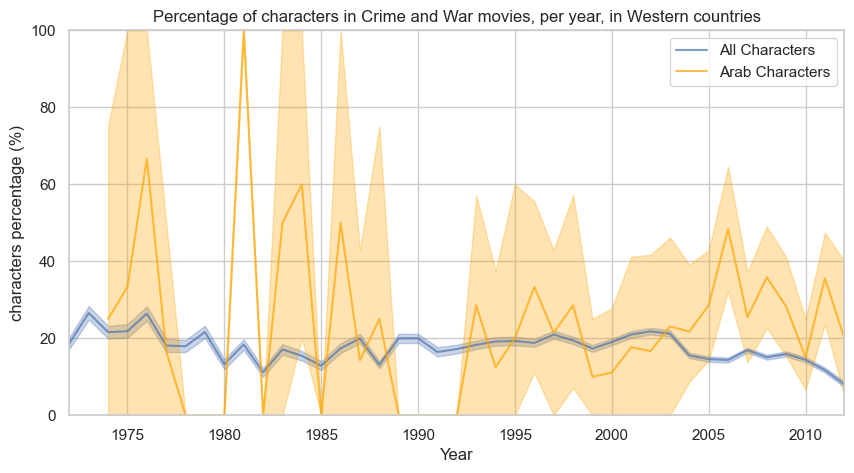

In [2038]:
# plot the yearly trend of characters with roles in crime and war movies, all characters and arab characters

plt.figure(figsize=(10,5))
plt.fill_between(conf_int_mc_w['release_date'], conf_int_mc_w['low']*100, conf_int_mc_w['up']*100, alpha=0.3, color='b')
plt.plot(cri_and_vio_western['release_date'],cri_and_vio_western['mean']*100, label='All Characters', alpha=0.7, color='b')

plt.fill_between(conf_int_mc_w['release_date'], conf_int_mc_w['low_ar']*100, conf_int_mc_w['up_ar']*100, alpha=0.3, color='orange')
plt.plot(cri_and_vio_ar_western['release_date'],cri_and_vio_ar_western['mean']*100, label='Arab Characters', alpha=0.7, color='orange')

plt.legend()
plt.xlabel('Year')
plt.ylabel('characters percentage (%)')
plt.xlim(1972, 2012)
plt.ylim(0,100)
plt.title('Percentage of characters in Crime and War movies, per year, in Western countries')
plt.show()

The plot on the yearly evolution on character percentage is really similar respect to the all word case. For arabs we definitely see strong fluctuations before 1993 for the lack of data points. As previously, this problem is faced taking two temporary bloks, one before and one after 9/11.

In [1929]:
# Consider all the characters in the western countries
# set the logistic regression model
model_4 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters_western)
result_4 = model_4.fit()
print(result_4.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     357.8
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           9.64e-80
Time:                        19:55:08   Log-Likelihood:            -1.0070e+05
No. Observations:              227292   AIC:                         2.014e+05
Df Residuals:                  227290   BIC:                         2.014e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1862      0.00

In [1930]:
# Create a new column for the treatment (after 2001)
movies_characters_ar_western.loc[:, 'treatment'] = movies_characters_ar_western['release_date'].apply(lambda x: 1 if x.year > 2001 else 0)

# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001]
treated = movies_characters_ar_western[movies_characters_ar_western['treatment']==1]
control = movies_characters_ar_western[movies_characters_ar_western['treatment']==0]

print('the treated population is {}.' .format(treated.shape[0]))
print('the control population is {}.' .format(control.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control['cri_and_vio_genres'].mean(), 3), round(control['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated['cri_and_vio_genres'].mean(), 3), round(treated['cri_and_vio_genres'].std(), 3)))


the treated population is 396.
the control population is 181.
The mean before 2001 is 0.204 with a standard deviation of 0.404.
The mean after 2001 is 0.283 with a standard deviation of 0.451.


In [1931]:
# Consider only the arab characters in the western countries
# set the logistic regression model
model_5 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=movies_characters_ar_western)
result_5 = model_5.fit()
print(result_5.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.001
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0459
Time:                        19:55:08   Log-Likelihood:                -339.95
No. Observations:                 577   AIC:                             683.9
Df Residuals:                     575   BIC:                             692.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2044      0.03

Similar results for the initial values, whereas the analysis on all the character is significant but the coefficient is negative, -0.0299, for the Arabs case we see a clear growth between control and treatmen group. The coefficient in fact is 0.0784, meaning a mean increase of 7,84%, with a p-value that is lower than 5% and therefore significative. 


## "Werstern countries" observational study

Firstly we analyse the confounders on treated and control groups, then we balance using the propensity score.

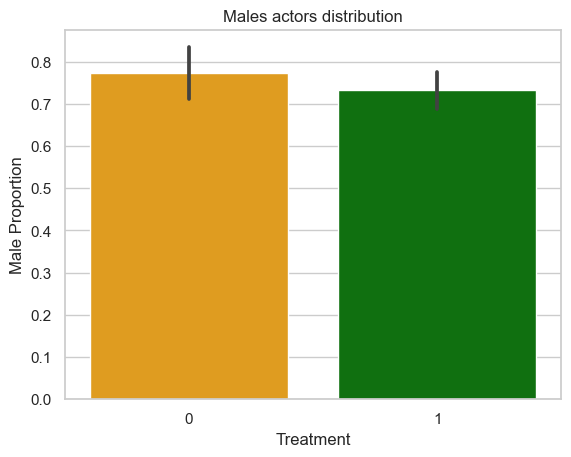

In [1932]:
# plot gender distributions for treated and control population
sns.barplot(x='treatment', y='M_onehot', data=movies_characters_ar_western[movies_characters_ar_western['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Males actors distribution')
plt.xlabel('Treatment')
plt.ylabel('Male Proportion')
plt.show()

Text(0, 0.5, 'Age')

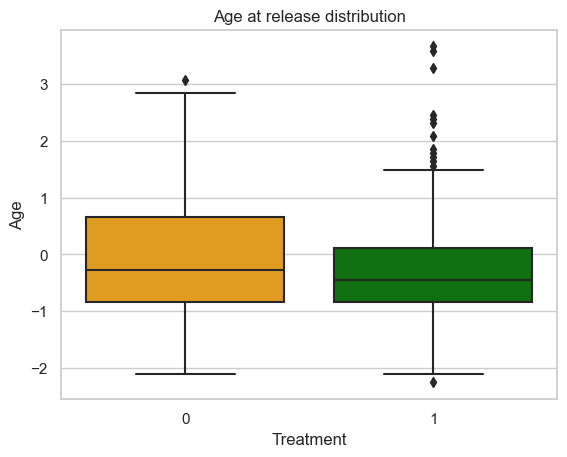

In [1933]:
# Plot for age distribution for treated and control population
sns.boxplot(x='treatment', y='age_at_release', data=movies_characters_ar_western[movies_characters_ar_western['treatment'].isin([0, 1])], palette=['orange', 'green'])
plt.title('Age at release distribution')
plt.xlabel('Treatment')
plt.ylabel('Age')

In [1934]:
# standardise the age
movies_characters_ar_western['age_at_release'] = (movies_characters_ar_western['age_at_release'] - movies_characters_ar_western['age_at_release'].mean())/movies_characters_ar_western['age_at_release'].std()

# set the logistic regression model for propensity score
mod = smf.logit(formula= 'treatment ~   age_at_release + C(M_onehot)',
                 data=movies_characters_ar_western)
res = mod.fit()

movies_characters_ar_western['Propensity_score'] = res.predict(movies_characters_ar_western)

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.658279
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  367
Model:                          Logit   Df Residuals:                      364
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                0.009779
Time:                        19:55:08   Log-Likelihood:                -241.59
converged:                       True   LL-Null:                       -243.97
Covariance Type:            nonrobust   LLR p-value:                   0.09202
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3817      0.245      1.557      0.119      -0.099       0.862
C(M_onehot)

In [1935]:
# Propensity score statistics
movies_characters_ar_western['Propensity_score'].describe()

count    367.000000
mean       0.618529
std        0.055693
min        0.399301
25%        0.589761
50%        0.630463
75%        0.652955
max        0.732778
Name: Propensity_score, dtype: float64

In [1936]:
# Similarity function
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [1938]:
# Separate the treatment and control groups
treated = movies_characters_ar_western[movies_characters_ar_western['treatment'] == 1]
control = movies_characters_ar_western[movies_characters_ar_western['treatment'] == 0]

# Create an empty graph
G=nx.Graph()

# Loop through all the pairs of instances
for treatment_id, treatment_row in treated.iterrows():
    for control_id, control_row in control.iterrows():
        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],  treatment_row['Propensity_score'])
                           
        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])
    

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [1939]:
# concatenate the tuple elements (couples) in a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [1940]:
# create the balanced dataset
balanced_ar_western = movies_characters_ar_western.loc[matched]

In [1941]:
# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001
treated_bal = balanced_ar_western[balanced_ar_western['treatment']==1]
control_bal = balanced_ar_western[balanced_ar_western['treatment']==0]

print('the treated population is {}.' .format(treated_bal.shape[0]))
print('the control population is {}.' .format(control_bal.shape[0]))

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(control_bal['cri_and_vio_genres'].mean(), 3), round(control_bal['cri_and_vio_genres'].std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(treated_bal['cri_and_vio_genres'].mean(), 3), round(treated_bal['cri_and_vio_genres'].std(), 3)))

the treated population is 140.
the control population is 140.
The mean before 2001 is 0.214 with a standard deviation of 0.412.
The mean after 2001 is 0.336 with a standard deviation of 0.474.


In [1942]:
# set the logistic regression model
model_6 = smf.ols(formula='cri_and_vio_genres ~ C(treatment)', data=balanced_ar_western)
result_6 = model_6.fit()
print(result_6.summary())

                            OLS Regression Results                            
Dep. Variable:     cri_and_vio_genres   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.237
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0229
Time:                        19:55:23   Log-Likelihood:                -168.93
No. Observations:                 280   AIC:                             341.9
Df Residuals:                     278   BIC:                             349.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2143      0.03

The model confirms a significant correlation between the treatment and the outcome, balancing the 2 groups with the propensity scores. Also, the increase before and after 2001 is 12,14% the largest seen in the analysis, from 21.43% to 33.57%.

The naive analysis confirms for both all world and western countries an increase of arab characters having parts in w&c movies after 2001. Since this correlation is still present after the balncing of the confounders, this support the existence of a **causal link** between Treatment and Outcome.

We could also plot the linear regression model, altough this is not too explicative since both the treatment and the outcome are binary.

Text(0, 0.5, 'Probability of being a crime and war movie')

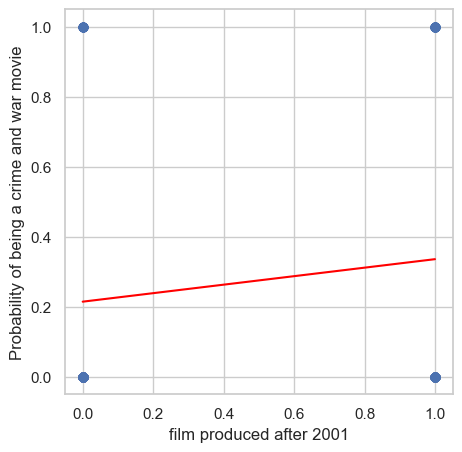

In [1943]:
# plot the linear regression model and the data
plt.figure(figsize=(5,5))
plt.scatter(balanced_ar_western['treatment'], balanced_ar_western['cri_and_vio_genres'])
plt.plot(balanced_ar_western['treatment'], result_6.predict(), color='red')
plt.xlabel('film produced after 2001')
plt.ylabel('Probability of being a crime and war movie')

We now sum up the results of the linear regression models. We divide the results before and after the balancing in two different summary dataframes

In [1944]:
# sum up the linear regression models before the balancing

summary_0 = pd.DataFrame({'model': ['All char.', 'Arab char.', 'All char.', 'Arab char.'],
                        'R2': [result_1.rsquared, result_2.rsquared, result_4.rsquared, result_5.rsquared],    
                        'p_value': [result_1.pvalues[1], result_2.pvalues[1], result_4.pvalues[1], result_5.pvalues[1]],
                        'intercept': [result_1.params[0], result_2.params[0], result_4.params[0], result_5.params[0]],
                        'coef': [result_1.params[1], result_2.params[1], result_4.params[1], result_5.params[1]],
                        'std_err': [result_1.bse[0], result_2.bse[0], result_4.bse[0], result_5.bse[0]]
                        })  

summary_0

,model,R2,p_value,intercept,coef,std_err
0,All char.,0.001090,6.725916e-75,0.165504,-0.023825,0.000912
1,Arab char.,0.004036,2.270667e-02,0.150776,0.051619,0.018234
2,All char.,0.001572,9.639670e-80,0.186161,-0.029924,0.001099
3,Arab char.,0.006910,4.594819e-02,0.204420,0.078408,0.032475


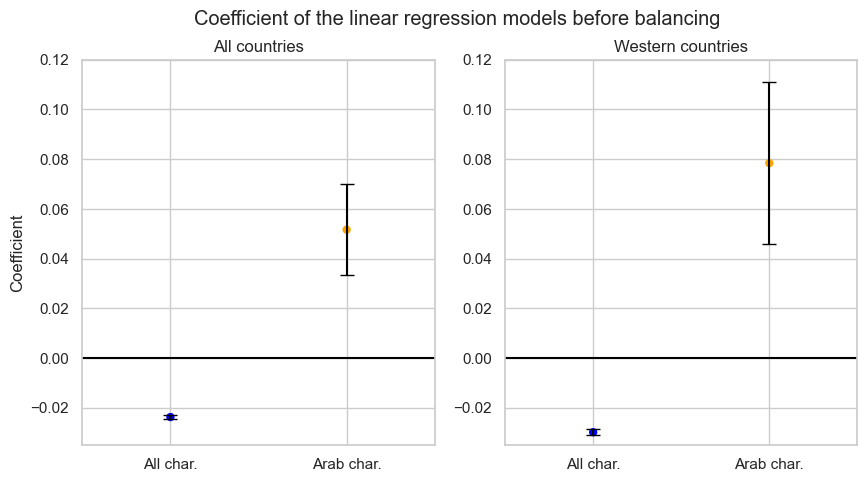

In [1945]:
#plot the coefficients with 2 subplots, one for all countries and one for western countries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Coefficient of the linear regression models before balancing')
ax1.scatter(summary_0['model'][:2], summary_0['coef'][:2], color=['blue', 'orange'], marker='.', s=100)
ax1.errorbar(x=summary_0['model'][:2], y=summary_0['coef'][:2], yerr=summary_0['std_err'][:2], fmt='none', c='black', capsize=5)
ax1.set_ylabel('Coefficient')
ax1.set_title('All countries')
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.035, 0.12)
ax1.axhline(y=0, xmin=0, xmax=1, color='black', linestyle='-')


ax2.scatter(summary_0['model'][2:], summary_0['coef'][2:], color=['blue', 'orange'], marker='.', s=100)
ax2.errorbar(x=summary_0['model'][2:], y=summary_0['coef'][2:], yerr=summary_0['std_err'][2:], fmt='none', c='black', capsize=5)
ax2.set_title('Western countries')
ax2.axhline(y=0, xmin=0, xmax=1, color='black', linestyle='-')
ax2.set_xlim(-0.5, 1.5)
ax2.set_ylim(-0.035, 0.12)
plt.show()

For the unbalanced data, we see a negative coefficient looking at the characters in general (blue dots) in both geographical scenarios. It means a decrease in participation in W&C movies compared to the ones published before and after 9/11. On the contrary, Arabs show a positive correlation (orange dots), but we cannot say that the one for Western countries is higher since the error bars intersect. In addition, the fact that the trend for non arabs is negative, is a first prove that the increase of arabs partecipation is not due to an increase of all the characters partecipation. We could be sure of this only setting another observationsl study analysing this all characters trend balancing for confounders.

Now, let's visualise results after balancing

In [1946]:
# the linear regression model after the balancing
# generate a dataframe with the results of models 3, 6
summary_bal = pd.DataFrame({'model': ['Arabs, all countries', 'Arabs, western countries'],
                        'R2': [result_3.rsquared, result_6.rsquared],    
                        'p_value': [result_3.pvalues[1], result_6.pvalues[1]],
                        'intercept': [result_3.params[0], result_6.params[0]],
                        'coef': [result_3.params[1], result_6.params[1]],
                        'std_err': [result_3.bse[0], result_6.bse[0]]
                        })
summary_bal


,model,R2,p_value,intercept,coef,std_err
0,"Arabs, all countries",0.006405,0.035565,0.144928,0.060870,0.020437
1,"Arabs, western countries",0.018489,0.022865,0.214286,0.121429,0.037521


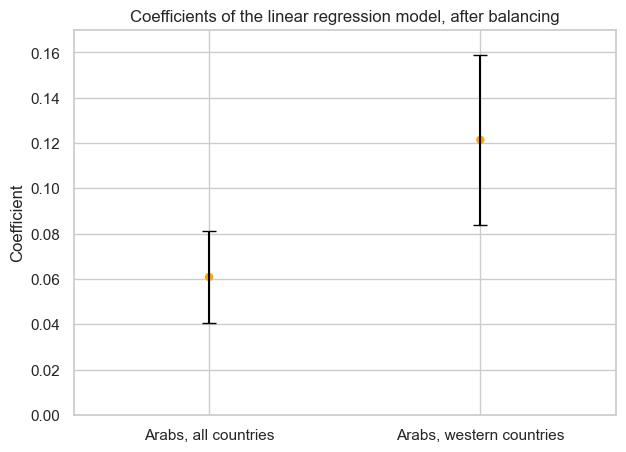

In [1947]:
# plot the summary results
plt.figure(figsize=(7,5))
plt.scatter(summary_bal['model'], summary_bal['coef'], color=['orange', 'orange'], marker='.', s=100)
plt.errorbar(x=summary_bal['model'], y=summary_bal['coef'], yerr=summary_bal['std_err'], fmt='none', c='black', capsize=5)
plt.ylabel('Coefficient')
plt.xlim(-0.5, 1.5)
plt.ylim(0, 0.17)
plt.title('Coefficients of the linear regression model, after balancing')
plt.show()

The results give support to the existence of a causal link, not confounded by the observed variables. Both models give positive coefficients with a significant p-value, with a 6% (all countries) and 12% (western countries) increase in probability for Arabs' participation in W&C movies. We can state that this correlation intensifies when accounting only for Western countries, in fact the two confidence intervals, made with standard deviation, do not intersect. This intuitively makes sense since these countries were the ones where 9/11 had the biggest cultural impact.

# Adding IMDb ratings and relevancy measure
This part was developed during P2. It was not used for our analysis in the end. 

Firstly, we import the IMDb dataset to populate the our data with user ratings.

In [1948]:
# IMPORTING IMDb DATASET
imdb_data_ratings = pd.read_csv(folder_std + "/imdb_ratings.tsv",sep='\t')
imdb_data_titles = pd.read_csv(folder_std + "/imdb_titles.tsv",sep='\t')
imdb_data = pd.merge(imdb_data_ratings,imdb_data_titles,on=['tconst'])

imdb_data = imdb_data.rename(columns={'primaryTitle': 'movie_name'})

imdb_data = imdb_data[['movie_name','averageRating']]
# imdb_data.head()

In [1949]:
# removing duplicate movie entries 
# by compressing them into 1 entry which is the mean
imdb_data_mean = imdb_data.groupby(['movie_name']).mean().reset_index().drop_duplicates()

In [1950]:
# making all titles lower-case to make merging more effective
imdb_data_mean['movie_name'] = imdb_data_mean['movie_name'].str.lower()
movies_characters_ar['movie_name'] = movies_characters_ar['movie_name'].str.lower()

# merging
movies_characters_ar_ratings = pd.merge(movies_characters_ar,imdb_data_mean,on=['movie_name'],how='left')

In [1951]:
# removing rows with NaN revenue data
filtered_movies_characters_ar_ratings = movies_characters_ar_ratings[movies_characters_ar_ratings['revenue'].notna() & movies_characters_ar_ratings['averageRating'].notna()]
filtered_movies_characters_ar_ratings.shape
# creating a year column
filtered_movies_characters_ar_ratings['release_year'] = filtered_movies_characters_ar_ratings['release_date'].dt.year

We compute the following indicator for each movie as a weighted sum of rating and revenue data: 
$$\textrm{coeff} = C1\cdot \overline{\textrm{revenue}} + C2\cdot \overline{\textrm{rating}}$$

Where the $\overline{\textrm{bar}}$ means the value is normalized with the movie's release year's mean and standard deviation.

In [1952]:
# Calculate the new column "relevance_coeff" (standardization by year)

weighting = [0.5, 0.5] # equal weights
filtered_movies_characters_ar_ratings['relevance_coeff'] = weighting[0] * ((filtered_movies_characters_ar_ratings['revenue'] - filtered_movies_characters_ar_ratings.groupby('release_year')['revenue'].transform('mean')) 
/ filtered_movies_characters_ar_ratings.groupby('release_year')['revenue'].transform('std')) + \
                        weighting[1]  * ((filtered_movies_characters_ar_ratings['averageRating'] - filtered_movies_characters_ar_ratings.groupby('release_year')['averageRating'].transform('mean')) 
                                         / filtered_movies_characters_ar_ratings.groupby('release_year')['averageRating'].transform('std'))

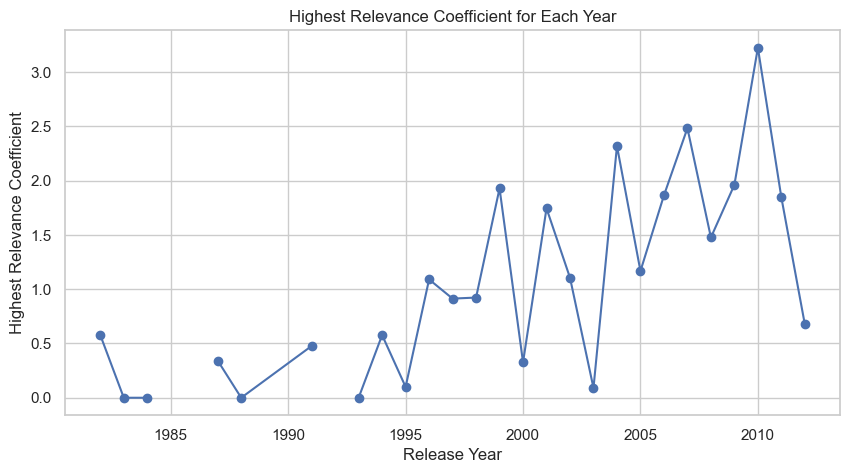

In [1953]:
plt.figure(figsize=(10,5))
max_relevance_per_year_ar = filtered_movies_characters_ar_ratings.groupby('release_year')['relevance_coeff'].max()

# Plot the results
plt.plot(max_relevance_per_year_ar.index, max_relevance_per_year_ar.values, marker='o', linestyle='-', color='b')
plt.xlabel('Release Year')
plt.ylabel('Highest Relevance Coefficient')
plt.title('Highest Relevance Coefficient for Each Year')
plt.show()

# Plot text analysis through NLP

It is important to verify that the characters we are considering are present in the plot. In fact, only these characters can be used for a sentiment analysis in the further stages of the project.

We want to import the plot summaries and add them to the current Dataframe, containing arab characters.

In [1954]:
# import the plot summaries
plot_summaries = pd.read_csv(folder_std + "/plot_summaries.txt",sep='\t',names=['wikiID','summary'])
plot_summaries.head()

,wikiID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [1955]:
# checking for NaN values
plot_summaries.isna().sum()

wikiID     0
summary    0
dtype: int64

In [1956]:
#checking the length distribution for the movie plots
plot_summaries['length_plot'] = plot_summaries['summary'].apply(lambda x: len(x))
plot_summaries

,wikiID,summary,length_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178
1,31186339,The nation of Panem consists of a wealthy Capi...,4559
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",220
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",2971
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,871
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",1289


In [1957]:
plot_summaries['length_plot'].describe()

count    42303.000000
mean      1784.034229
std       1808.925536
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: length_plot, dtype: float64

We can see from the describe function that the distribution of movie plots is very spread as the mean as big as the standard deviation. In addition, we have a movie plot with 28159 characters which may suggest that there are outliers, since the upper quartile is much smaller than the maximum. We decide to look at it more closely using a box plot.

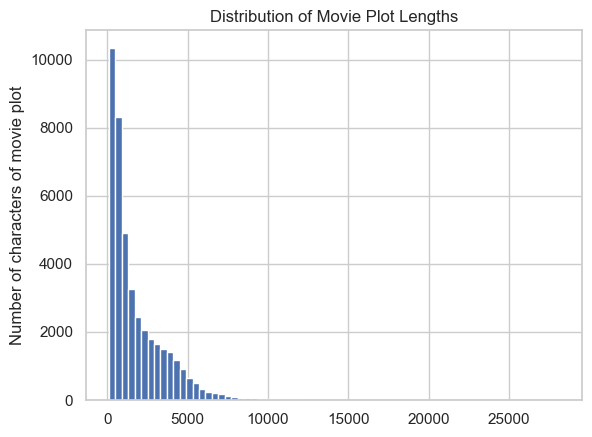

In [1958]:
plot_summaries.hist(column=['length_plot'],bins=70)
# Add titles to the plot and axes
plt.title('Distribution of Movie Plot Lengths')
plt.ylabel('Number of characters of movie plot')
# Show the plot
plt.show()

Our intuition was right. We can see from the histogram that the distribution of length of the movie plots is heavy tailed. Consequently, we decide to show the distribution with a boxplot employing a logarithmic scale for the y-axis, to make the visualization more interpretable.

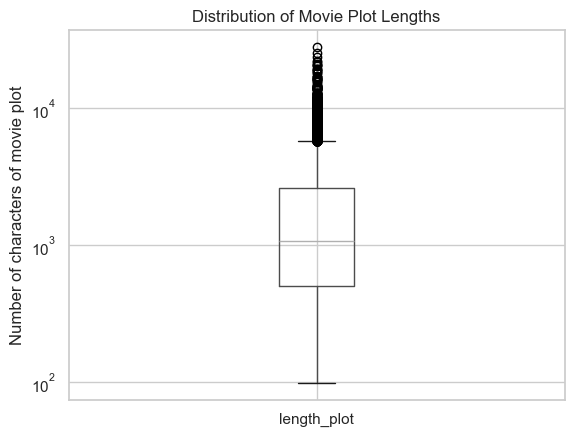

In [1959]:
plot_summaries.boxplot(column=['length_plot'])
plt.yscale('log')
# Add titles to the plot and axes
plt.title('Distribution of Movie Plot Lengths')
plt.ylabel('Number of characters of movie plot')

# Show the plot
plt.show()

## Named entity recognition

We need to a partial preprocessing of the summaries before feeding the text to the spacy model to perform named entity recognition. For example, for movie number 4075 in the movie plots dataset, the plot begins with "{{Further2}}", which maybe recognized as an entity. We only do a partial preprocessing to remove alpha numeric characters and some punctuation. We will not make the text to lower case since the model uses the cases information and the model processes the raw text and do some preprocessing internally (for example removal of stopwords).

In [1960]:
def partial_preprocess_for_ner(text):
    words = text.split()
    punctuation=list(string.punctuation)
    p= [word for word in words if word.isalpha() and word not in punctuation]
    res = " ".join([word for word in p])
    return res

We employ the spaCy tool, utilizing the 'en_core_web_sm' model, to conduct a linguistic analysis of movie plots. spaCy, a language processing tool, possesses capabilities such as sentence breakdown, word tagging, and named entity recognition (NER). Specifically, we leverage its NER functionality to identify individuals in film summaries. Our interest lies in determining whether these individuals bear Arabic names. To achieve this, we cross-reference the identified names from spaCy with a dataset containing Arabic names.

In [1961]:
# We run this cell once, than we save the results in a csv file

# NER MODEL (takes 54m 46.9s)
'''
model = spacy.load("en_core_web_sm") 
 
def extract_entities(text):
    doc = model(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

# Apply the function to the DataFrame and create a new column for named entities
plot_summaries['named_entities'] = plot_summaries['summary'].apply(partial_preprocess_for_ner)
plot_summaries['named_entities'] = plot_summaries['summary'].apply(extract_entities)
plot_summaries

# write plot summaries to a file csv
plot_summaries.to_csv(folder_add + "/basic_preprocessed_ner.csv")

'''


'\nmodel = spacy.load("en_core_web_sm") \n \ndef extract_entities(text):\n    doc = model(text)\n    entities = [(entity.text, entity.label_) for entity in doc.ents]\n    return entities\n\n# Apply the function to the DataFrame and create a new column for named entities\nplot_summaries[\'named_entities\'] = plot_summaries[\'summary\'].apply(partial_preprocess_for_ner)\nplot_summaries[\'named_entities\'] = plot_summaries[\'summary\'].apply(extract_entities)\nplot_summaries\n\n# write plot summaries to a file csv\nplot_summaries.to_csv(folder_add + "/basic_preprocessed_ner.csv")\n\n'

In [1962]:
# read the file
plot_summaries = pd.read_csv(folder_add + "/basic_preprocessed_ner.csv").drop(['Unnamed: 0'], axis=1)
plot_summaries.head()

,wikiID,summary,length_plot,named_entities
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[('Lyosha', 'PERSON')]"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[('Panem', 'ORG'), ('Capitol', 'ORG'), ('twelv..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[('Poovalli Induchoodan', 'PERSON'), ('six yea..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[('New York City', 'GPE'), ('Florida', 'GPE'),..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[('Seventh-day', 'DATE'), ('Adventist Church',..."


In [1963]:
# We make a deep copy of the dataframe, before filtering in subsequent cells
plot_summaries_chars = plot_summaries.copy()

In [1964]:
# Remove brackets in named_entities column
plot_summaries_chars['named_entities']= plot_summaries_chars['named_entities'].apply(lambda x: ast.literal_eval(str(x)))

In [1965]:
#we do a set so that we only count each entity one time.
plot_summaries_chars["Chars in plot"] = plot_summaries_chars['named_entities'].apply(lambda x: 
   set( [ entity for entity in x if entity[1] == "PERSON"])
)
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Rue, PERSON), (Haymitch, PERSON), (baker, PE..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Karunakara Menon, PERSON), (Indulekha, PERSO..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Nellie, PERSON), (Moose Moran, PERSON), (Hen..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael Chamberlain, PERSON), (Lindy, PERSON..."


In [1966]:
all_chars = [char for sublist in plot_summaries_chars['Chars in plot'] for char in sublist]
chars_counts = Counter(all_chars)
chars_counts.most_common(10)

[(('Jack', 'PERSON'), 608),
 (('John', 'PERSON'), 583),
 (('Tom', 'PERSON'), 571),
 (('Sam', 'PERSON'), 494),
 (('Mary', 'PERSON'), 482),
 (('Joe', 'PERSON'), 479),
 (('David', 'PERSON'), 462),
 (('Paul', 'PERSON'), 440),
 (('Michael', 'PERSON'), 420),
 (('Peter', 'PERSON'), 407)]

In [1967]:
# Take only character names
char_names = [x[0] for x in all_chars]

In [1968]:
#get the top 10 arabic names mentionned in the movie plots
res = []
for element,count in chars_counts.items():
    name = str(element[0]).lower()
    if(name in arab_names):
        res.append((name,count))
    
res = sorted(res, key=lambda pair: pair[1], reverse=True)
res[:10]

[('ali', 109),
 ('omar', 33),
 ('hassan', 28),
 ('malik', 28),
 ('salim', 27),
 ('abbas', 24),
 ('fatima', 23),
 ('rahman', 22),
 ('aman', 22),
 ('samir', 20)]

In [1969]:
# Add a column to the dataframe that indicates if the movie plot contains an arabic name
plot_summaries_chars['has_arabic_character'] = plot_summaries_chars['Chars in plot'].apply(lambda x: any(str(entity[0]).lower() in arab_names for entity in x))

# New dataframe, filtering on movies with arabic characters
movies_with_arabic = plot_summaries_chars[plot_summaries_chars['has_arabic_character']==True]
display(movies_with_arabic.head())
print(f'There are {movies_with_arabic.shape[0]} movies with arabic characters')

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Dov Landau, PERSON), (Ari Ben Canaan's, PERS...",True
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True
46,19174305,"Tahaan lives with his grandfather , mother Ha...",2091,"[(Tahaan, GPE), (Haba, ORG), (Zoya, PERSON), (...","{(Zoya, PERSON), (Birbal, PERSON), (Tahaan, PE...",True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Mask, PERSON), (Monique, PERSON), (Jamal, PE...",True


There are 897 movies with arabic characters


### Pre-processing pipeline for wordcloud

We want to visualize the most recurrent words that appear in teh movie plots that mention an arabic character and compare it with the same visualization for movies that do not mention arabic characters. 

To do so, we need to pre-process plot summaries so that we can evaluate the most meaningful words in each plot. First, we remove punctuation and english stopwords (provided by nltk library). Secondly, we lemmatize. We chose lemmatization over stemming because it is more accurate and our dataset is not large, making the computational time acceptable.

In [1970]:
#nltk lemmatizer
wl=WordNetLemmatizer()
punctuation=list(string.punctuation)



#preprocessing for topic modeling 
def preprocess_text(text,stopwords):
    text = text.lower()
    words = text.split()
    #convert stopwords and words of text into set to improve runtime 
    new_stopW = set(words).intersection(stopwords)
    p= [word for word in words if word.isalpha() and word not in new_stopW]
    text= " ".join([wl.lemmatize(word) for word in p])
    
    
    return text

In [1971]:
# Apply the preprocessing function to the summaries
movies_with_arabic.loc[:,1]= movies_with_arabic['summary'].apply(lambda x:preprocess_text(x,list(STOPWORDS)))

movies_with_arabic.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,1
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Dov Landau, PERSON), (Ari Ben Canaan's, PERS...",True,film based event happened ship exodus event de...
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True,following sudden death father local church don...
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True,anna khitrova midwife london find diary body g...
46,19174305,"Tahaan lives with his grandfather , mother Ha...",2091,"[(Tahaan, GPE), (Haba, ORG), (Zoya, PERSON), (...","{(Zoya, PERSON), (Birbal, PERSON), (Tahaan, PE...",True,tahaan life grandfather mother haba older sist...
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Mask, PERSON), (Monique, PERSON), (Jamal, PE...",True,film begin boy named michael kid hots beautifu...


In [1972]:
# Helper function to plot wordclouds
def make_WC_visualization(data,mask=None):
    text =  " ".join(data) 
    wc = WordCloud(background_color='white',colormap='copper',max_words=100,mask=mask, width = 800, height = 500).generate(text)
    plt.imshow(wc)
    plt.axis("off")

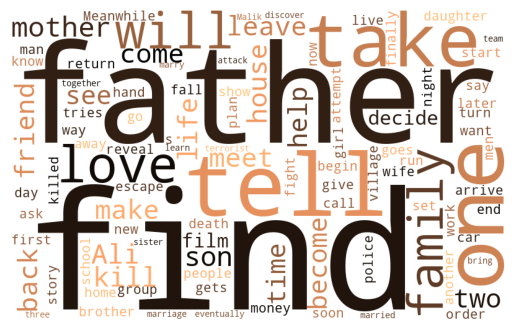

In [1973]:
# Wordcloud visualization of the 100 most common words in the movie plots
make_WC_visualization(movies_with_arabic['summary'])

Now we want to show the wordcloud for movies without arab characters in the plot.

In [1974]:
movies_with_nonarabs = plot_summaries_chars[plot_summaries_chars['has_arabic_character']==False]
movies_with_nonarabs.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Rue, PERSON), (Haymitch, PERSON), (baker, PE...",False
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Karunakara Menon, PERSON), (Indulekha, PERSO...",False
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Nellie, PERSON), (Moose Moran, PERSON), (Hen...",False
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael Chamberlain, PERSON), (Lindy, PERSON...",False


In [1975]:
movies_with_nonarabs['summary'] = movies_with_nonarabs['summary'].apply(lambda x:preprocess_text(x,list(STOPWORDS)))
movies_with_nonarabs.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
0,23890098,taxi driver develop bizarre despite realize di...,178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False
1,31186339,nation panem consists wealthy capitol poorer p...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Rue, PERSON), (Haymitch, PERSON), (baker, PE...",False
2,20663735,poovalli induchoodan sentenced year prison lif...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Karunakara Menon, PERSON), (Indulekha, PERSO...",False
3,2231378,lemon drop kid new york city illegally touting...,4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Nellie, PERSON), (Moose Moran, PERSON), (Hen...",False
4,595909,adventist church pastor michael wife daughter ...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael Chamberlain, PERSON), (Lindy, PERSON...",False


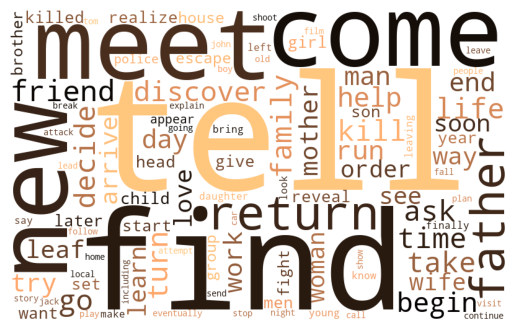

In [1976]:
make_WC_visualization(movies_with_nonarabs['summary'])

We can see clearly from the wordcloud visualization that the lexical field differ: for the movies with arabic have much more words with bad conotation, like kill, drugs, help, and attack whereas for the movies in which the plot doesn't mention an arabic character, the most repeated words are more neutral and/or more positive for example family, life, son ,decide... Eventhough both negative words and positive words in both categories, it is worth noting that the scales for the words in common differ: for example the word kill, we can see that it is bigger in the movies with arabic characters. Eventhough, the number of films of each categories vary a lot since we don't have much arabic characters mentioned in the plot(897 vs 41406), it is worth extending our research to also check for arabic locations and also check for movies where arabic characters plays a secondary role and is not mentioned in the plot.

In [1977]:
# Add the country feature to the plot_summaries_chars dataframe
plot_summaries_chars = pd.merge(plot_summaries_chars, movies[['wikiID','countries','release_date']], left_on='wikiID',right_on='wikiID', how='left')
plot_summaries_chars.head()

# We want to filter the years to only include movies between 1972 and 2012
limit_years = [1972, 2013]
plot_summaries_chars = plot_summaries_chars[plot_summaries_chars['release_date'].dt.year.isin(range(limit_years[0],limit_years[1]))]

In [1978]:
# drop the rows with NaN values in the countries column
plot_summaries_chars.dropna(inplace=True, subset=['countries'])
plot_summaries_chars['is_western_country'] = plot_summaries_chars['countries'].apply(lambda x: not set(x).isdisjoint(set(western_countries)))
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False,"[France, Soviet Union, Russia]",1990-09-07,True
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Rue, PERSON), (Haymitch, PERSON), (baker, PE...",False,[United States of America],2012-03-12,True
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Karunakara Menon, PERSON), (Indulekha, PERSO...",False,[India],2000-01-01,False
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Michael Chamberlain, PERSON), (Lindy, PERSON...",False,"[United States of America, Australia, New Zeal...",1988-11-03,True
5,5272176,The president is on his way to give a speech. ...,1937,"[(Alex Thomas, PERSON), (Alex, PERSON), (Kate ...","{(Thomas, PERSON), (Alex Thomas's, PERSON), (A...",False,"[United States of America, Canada, Germany]",2006-01-01,True


In [1979]:
# movies with arabic characters from western countries
movies_ar_western = plot_summaries_chars[(plot_summaries_chars['has_arabic_character']) & (plot_summaries_chars['is_western_country'])]

movies_ar_western.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True,[United States of America],1991-10-23,True
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True,"[United States of America, Canada, United King...",2007-09-08,True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Mask, PERSON), (Monique, PERSON), (Jamal, PE...",True,[United States of America],2000-01-01,True
84,1282593,It is spring. Randy Dean is a high school seni...,3620,"[(Randy Dean, PERSON), (only one, CARDINAL), (...","{(Ali, PERSON), (Rubyfruit Jungle, PERSON), (R...",True,[United States of America],1995-01-01,True
108,3662683,"On the morning after his re-election, US Presi...",3101,"[(the morning, TIME), (US, GPE), (Joseph Stato...","{(Martin, PERSON), (Iqbal, PERSON), (Joseph St...",True,[United States of America],2006-04-21,True


In [1980]:
# Movies from western countries
movies_western = plot_summaries_chars[plot_summaries_chars['is_western_country']]
char_percent = movies_ar_western['has_arabic_character'].sum()/movies_western.shape[0]
print(f'Percentage of characters in the summary: {char_percent:.3}')
print(f'Number of characters in the summary: {movies_ar_western["has_arabic_character"].sum()}')
print(f'Number of characters not in the summary: {movies_western.shape[0]-movies_ar_western["has_arabic_character"].sum()}')

Percentage of characters in the summary: 0.0161
Number of characters in the summary: 285
Number of characters not in the summary: 17389


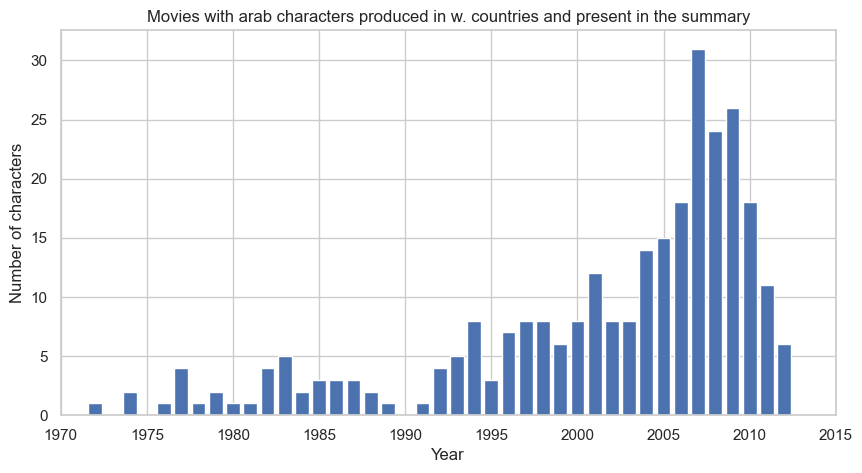

Movies with arab characters present in the summary before 2001: 106
Movies with arab characters present in the summary after 2001: 179


In [1981]:
# Plot the yearly number of arab characters in movies pubblished in USA, present in the summary


plt.figure(figsize=(10,5))
yearly_ar_we_movies = movies_ar_western.groupby(movies_ar_western['release_date'].dt.year)['has_arabic_character'].sum().reset_index(name='characters_ar_we_inplot')
plt.bar(yearly_ar_we_movies['release_date'],yearly_ar_we_movies['characters_ar_we_inplot'])
plt.xlim(1970,2015)
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Movies with arab characters produced in w. countries and present in the summary')
plt.show()

print(f'Movies with arab characters present in the summary before 2001: {yearly_ar_we_movies[yearly_ar_we_movies["release_date"]<=2001]["characters_ar_we_inplot"].sum()}')
print(f'Movies with arab characters present in the summary after 2001: {yearly_ar_we_movies[yearly_ar_we_movies["release_date"]>2001]["characters_ar_we_inplot"].sum()}')

## Assessing accuracy of arab names identification

Arab names list has been slightly changed from the one provided in milestone 2. In particular, the task of eliminating names which are likely to be present in other cultures from the Wikipedia list of arabic names is now assigned to a large language model (i.e. chatGPT) instead of being done manually. This approach provides better accuracy of the filtered list and, subsequently, of the identification of arab characters in movie plots. In general, the approach consists in identifying names that most probably correspond to arab characters eliminating ambiguous ones, to prioritize the accuracy of the selection to the number of characters. The resulting list does not change significantly.

In [1982]:
# Read the file
with open(folder_add+'/arab_names.txt', 'r') as file:
    names = file.readlines()

# Clean and format the names (with list comprehension)
arab_names = [' '.join(name.strip().split(' ')[0:-1]) if '(name)' in name else ' '.join(name.strip().split(' ')[0:-2]) if '(given name)' in name else name.strip() for name in names]

arab_names = [str(item).lower() for item in arab_names]

# Read the csv file generated by chatGPT interface, with arab names common in other cultures
common_names_df = pd.read_csv(folder_add+'/common_names.csv', header=None)

# Convert DataFrame to a list of lowercase names
common_names = common_names_df[0].str.lower().tolist()

# Filter arab names from common names
arab_names = [name for name in arab_names if name not in common_names]
arab_names[:10]

['abbad',
 'abbas',
 'abd al-uzza',
 'abdus salam',
 'abd manaf',
 'abd rabbo',
 'abdel fattah',
 'abdel nour',
 'abdi',
 'abdolreza']

Another important point to validate our analysis is understanding how well the arabic names recognition of our model works. To do so, our character names resulting from the Named entity recognition through `"en_core_web_sm"` spacy model and then intersected to the list `arabic_names`, are compared with the results of the large language model chatGPT. 50 randomly chosen plots containing at least one arab name are used to do this manual check.

The following cell is run the first time to get the 50 random plots. After ChatGPT genates the json file of results, this file is saved and the indices (wikiID) of the randomly selected movies are retrieved by using the aformentioned file.


In [1983]:
'''
# Select 50 random movies containing at least one arab character
movies_with_arabic_sample = movies_with_arabic.sample(n=50, random_state=1)

# Series of lists of arab characters in the sample plots
output = movies_with_arabic_sample['Chars in plot'].apply(lambda x: [entity[0] for entity in x if entity[0].lower() in arab_names])
pd.reset_option('display.max_colwidth')
movies_with_arabic_sample.head()
'''

"\n# Select 50 random movies containing at least one arab character\nmovies_with_arabic_sample = movies_with_arabic.sample(n=50, random_state=1)\n\n# Series of lists of arab characters in the sample plots\noutput = movies_with_arabic_sample['Chars in plot'].apply(lambda x: [entity[0] for entity in x if entity[0].lower() in arab_names])\npd.reset_option('display.max_colwidth')\nmovies_with_arabic_sample.head()\n"

In [1984]:
# Results obtained from the chatGPT interface
import json

# Reading the dictionary from the JSON file
with open(folder_add + '/arab_names_in_plots_chatGPT.json', 'r') as json_file:
    arab_names_in_plots_chatGPT = json.load(json_file)

# Converting keys of the dictionary from string to integer
arab_names_in_plots_chatGPT = {int(k): v for k, v in arab_names_in_plots_chatGPT.items()}
arab_names_in_plots_chatGPT = dict(sorted(arab_names_in_plots_chatGPT.items()))

# Movies with arabic sample have the same wikiID as the keys of the dictionary, randomly generated by chatGPT
movies_with_arabic_sample = movies_with_arabic[movies_with_arabic['wikiID'].isin(arab_names_in_plots_chatGPT.keys())]
# sort with the same order as the keys of the dictionary
movies_with_arabic_sample = movies_with_arabic_sample.sort_values(by=['wikiID'])


output = movies_with_arabic_sample['Chars in plot'].apply(lambda x: [entity[0] for entity in x if entity[0].lower() in arab_names])

# Example: Accessing data for the first movie of the sample
arab_names_in_plots_chatGPT[movies_with_arabic_sample.iloc[1]['wikiID']]

['Uday Singh Rathod', 'Maya Solomon', 'Harsh', 'Ali', 'Shyamoli']

In [1985]:
# Display the dataframe with the sample of movies
movies_with_arabic_sample.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,1
15563,1055569,England manager Phil Cope suffers a heart atta...,3675,"[(England, GPE), (Phil Cope, PERSON), (the Wor...","{(Premiership, PERSON), (Atomic Kitten, PERSON...",True,england manager phil cope suffers heart attack...
6767,1396697,Uday Singh Rathod is a law-abiding police off...,2996,"[(Uday Singh Rathod, PERSON), (Maya Solomon, P...","{(Maya, PERSON), (Ali, PERSON), (Harsh, PERSON...",True,uday singh rathod police famous extraordinary ...
41778,1510273,"Chili Palmer helps Edie Athens , the widow of...",3310,"[(Edie Athens, PERSON), (Tommy Athens, PERSON)...","{(Joe Loop, PERSON), (Nick Carr, PERSON), (Lin...",True,chili palmer help edie athens widow executed t...
3240,2005119,Sabah is a 40-year-old single immigrant from S...,1791,"[(Sabah, PERSON), (40-year-old, DATE), (Syria,...","{(Sabah, PERSON), (Majid, PERSON)}",True,sabah single immigrant syria living toronto re...
21602,2156850,Three different people from different continen...,2643,"[(Three, CARDINAL), (South Asian, NORP), (Isla...","{(FATA, PERSON), (Mansoor, PERSON), (Maulana, ...",True,different people different continent problem r...


In [1986]:
# Check on the lenghts of the lists
print(f'Number of movies with arab characters: {len(arab_names_in_plots_chatGPT)}')
print(f'Number of movies in the sample: {movies_with_arabic_sample.shape[0]}')

Number of movies with arab characters: 50
Number of movies in the sample: 50


In [1987]:
# Compare the two results
# Build a dataframe with the results from the chatGPT interface and our results in two columns, to visually copare them
comparison = pd.DataFrame(columns=['movie_name','arab_names_in_plots_chatGPT','our_results'])

comparison['movie_name'] = movies.merge(movies_with_arabic_sample, on='wikiID', how='inner')['movie_name']
comparison['arab_names_in_plots_chatGPT'] = arab_names_in_plots_chatGPT.values()
comparison['our_results'] = output.values
pd.set_option('max_colwidth', None)
display(comparison)
pd.reset_option('display.max_colwidth')

,movie_name,arab_names_in_plots_chatGPT,our_results
0,The Boys from Baghdad High,"[Lonnie Urquart, Bashir]",[Bashir]
1,Muqaddar Ka Sikandar,"[Uday Singh Rathod, Maya Solomon, Harsh, Ali, Shyamoli]",[Ali]
2,Boulevard,[],[Raji]
3,Hearts of Freedom,"[Sabah, Majid, Souhaire]","[Sabah, Majid]"
4,Staying Alive,"[Mansoor, Sarmad, Mary/Mariam, Dave, Maulana]",[Sarmad]
5,DP75: Tartina City,"[Muhammad, Hamza ibn `Abd al-Muttalib, Abu Sufyan, Hind bint Utbah]",[Muhammad]
6,Cartouches Gauloises,[Dr. Aziz Ahmed],[Aziz]
7,United 93,"[Ahmed al-Nami, Ahmed al-Haznawi, Ziad Jarrah, Saeed al-Ghamdi, Mohamed Atta, Ben Sliney]",[Jarrah]
8,Mike Bassett: England Manager,"[Mr. Contant, Valerie Bates, Russ Thorn, Linda, Diane, John, Jeff, Neil, Mrs. Jana, Kim, Trish, Courtney, Coach Jana]",[Jana]
9,Sabah,"[Salim, Halim, Baqar, Sikander, Kazim, Amina, Shamshad, Ajmani]","[Salim, Halim]"


As it is visible from the resulting DataFrame, chatGPT is able to capture many more Arab characters than our model. This is because the detection the large language model does is based on the context of the entire plots, making it possible to identify as arabs also names that are not strictly coming from the arabic culture. This can be seen as a limitation for our model. On the other hand, some names are detected by our analysis and are not actually considered Arab characters by chatGPT, because they come from a close culture but are not actually Arab. This can be a problem as well, as movies without actual Arab characters may be taken into consideration. However, it can be said that this second scenario, the most critic one, occurs only 5 out of 50 samples while in the other cases the movie containing an Arab character is correctly detected. This would mean that for most cases there is a limitation on the number of Arab characters found but not on the movie identification.

We chose to use Jaccard similarity to quantify the similarity of the two sets.

In [1988]:
# Function to split lists of complex names into single name
def split_strings_into_words(input_list):
    # Using a nested list comprehension to split each string into words
    result_list = [word for phrase in input_list for word in phrase.split()]
    return result_list

# Function to calculate the Jaccard similarity between two lists
def jaccard_similarity(list1, list2):
    # names are considered the same if they have at least one word in common
    same_names = [name for name in list1 if any(word in split_strings_into_words(list2) for word in name.split())]
    intersection = len(same_names)
    union = (len(list1) + len(list2)) - intersection
    return round(float(intersection) / union, 3)

In [1989]:
# Calculate the Jaccard similarity between the two lists
comparison['jaccard_similarity'] = comparison[['arab_names_in_plots_chatGPT','our_results']].apply(lambda x: jaccard_similarity(x[0],x[1]), axis=1)

comparison.head()

,movie_name,arab_names_in_plots_chatGPT,our_results,jaccard_similarity
0,The Boys from Baghdad High,"[Lonnie Urquart, Bashir]",[Bashir],0.500
1,Muqaddar Ka Sikandar,"[Uday Singh Rathod, Maya Solomon, Harsh, Ali, ...",[Ali],0.200
2,Boulevard,[],[Raji],0.000
3,Hearts of Freedom,"[Sabah, Majid, Souhaire]","[Sabah, Majid]",0.667
4,Staying Alive,"[Mansoor, Sarmad, Mary/Mariam, Dave, Maulana]",[Sarmad],0.200


In [1990]:
# Average jaccard similarity between the 50 sample cases
print(f'Average Jaccard similarity between the two lists: {comparison["jaccard_similarity"].mean():.3}')

Average Jaccard similarity between the two lists: 0.294


# Sentiment analysis

Our goal is now perform a sentiment analysis on the movie plots provided in the dataset. In particular, our interest is assessing the sentiment associated with the detected arabic characters. This analysis will be performed on the western movies, and a comparison will be done for the case before and after 2001.

The DataFrame to be used is consequently `movies_ar_western`, already filtered for movies delivered in western countries, with the presence of at least one Arab character.

In [1991]:
# Reminder of how the DataFrame looks like
movies_ar_western.columns

Index(['wikiID', 'summary', 'length_plot', 'named_entities', 'Chars in plot',
       'has_arabic_character', 'countries', 'release_date',
       'is_western_country'],
      dtype='object')

We choose to start with an example of a single movie plot to better understand the features and the outputs of the model. The choice was a randomly selected movie called "House Party 2" of the year (1991). For this example movie plot, histograms of positive, negative and compound sentiment are show, as well as their mean values.

In [2052]:
# Take as example plot the movie "House party 2" (1991)
ID_example = movies[movies['movie_name']== 'House Party 2']['wikiID']
example = movies_ar_western[movies_ar_western['wikiID']==ID_example.values[0]]['summary'].values[0]
print('We take as an example this movie plot:\n {}'.format(example))

We take as an example this movie plot:
 {{plot}} Following the sudden death of Kid's father "Pop" the local church has donated a scholarship fund to Kid so that he can go to college. Play now drives a sports car called "Foreplay" and is the manager of a record store. He attracts the attention of music producer Shelia Landreaux whose talent scout Rick spotted Kid N' Play performing at a community center. Shelia is willing to help finance Kid N'Play's demo session if they can commit to taking the act to the top of the charts. Kid however immediately backs out because he can't commit to the act and go to school, causing a rift between the two friends. Kid and Sydney both move into new student accommodations where Kid's room mate is Jamal, a white rapper and Sydney moves in with Zora, a strong minded female student who embraces strong political correctness. Meanwhile, Play meets a beautiful older woman named Salena who he flirts with and offers to help her with any thing she needs. Unfortu

The VADER model is used to evaluate the sentiment score of the words in a text. The sentiment score consists of four values: neutral, positive and negative which sum to one. The final score is obtained by thresholding the compound value (e.g. +/-0.05).

In [2053]:
# load VADER model
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(example)

In [2054]:
# Total sentiment present of the plot
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Negative sentiment: 0.083
Neutral sentiment: 0.761
Positive sentiment: 0.156
Compound sentiment: 0.9986


In [2055]:
# NLP model definition
model = spacy.load("en_core_web_sm") 
doc = model(example)

Text(0, 0.5, 'Number of sentences')

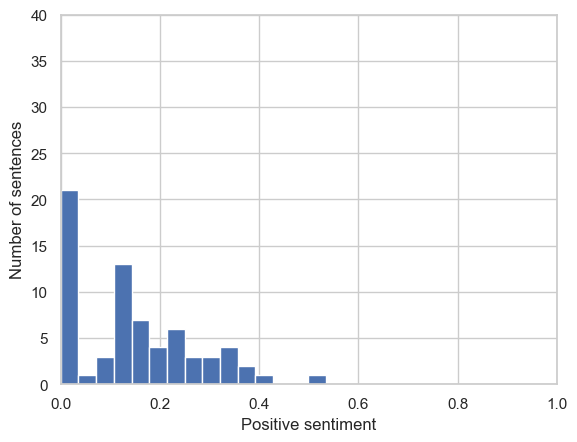

In [2056]:
positive_sent = []
# Iterate through the sentences, get polarity scores, choose a value
[positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
plt.hist(positive_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,40])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

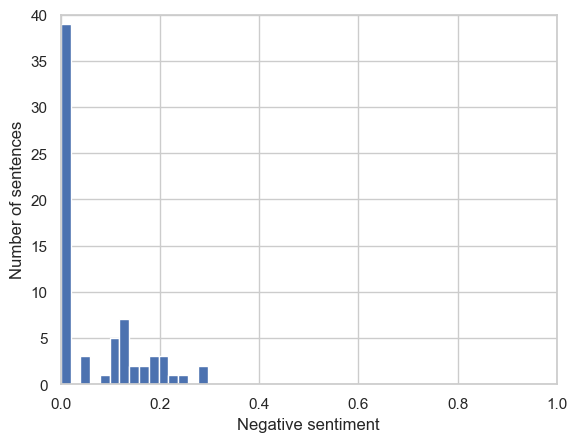

In [2057]:
negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in doc.sents]
plt.hist(negative_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,40])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')

Text(0, 0.5, 'Number of sentences')

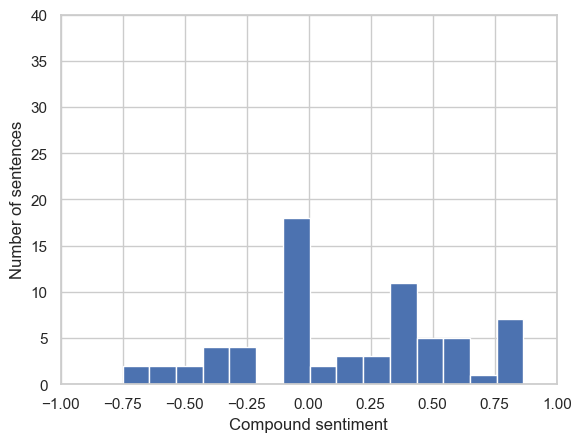

In [2058]:
total_sent = []
[total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
plt.hist(total_sent,bins = 15)
plt.xlim([-1,1])
plt.ylim([0,40])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences')

This is the overall sentiment throughout this particular plot summary. The next step is measuring the sentiment around the arab characters in the plot.

We evaluate that, to have a more precise measure of how Arab characters are depicted in movies we should restrict the field of analysis. The mainly evaluated strategies were:
- analyze the senteces where the target words were present
- analyze the local contexts around the target words (range of n words before and after)

Both strategies can be considered good. However, the second strategy is chosen, as it is evaluated that some useful information about the character can be present also in different senteces, given the fact that they are close in position, while in a single sentence multiple characters could be present. Note that the function created does not preprocess text, thus also considers stopwords. This is not a problem for sentiment analysis as such words are detected as a null contribute to the sentiment, but it is important to consider quite "large" local contexts to account for their presence.

In [2059]:
# Create a column of arabic characters in the plot
movies_ar_western['arabic_chars'] = movies_ar_western['Chars in plot'].apply(lambda x: [entity[0] for entity in x if entity[0].lower() in arab_names])
arabic_char_example = movies_ar_western[movies_ar_western['wikiID']==ID_example.values[0]]['arabic_chars'].values[0]

print('Arab characters in the example plot:')
print(arabic_char_example)

Arab characters in the example plot:
['Bilal']


In [2060]:
# find the position of the arabic characters in the plot (Bilal)
pos_arab_name = [(e.start, e.end) for e in doc.ents if e.label_ == 'PERSON' and e.text in arabic_char_example]
pos_arab_name

[(194, 195),
 (455, 456),
 (564, 565),
 (729, 730),
 (795, 796),
 (802, 803),
 (924, 925),
 (1184, 1185),
 (1362, 1363),
 (1420, 1421)]

In [2066]:
# Create a smaller document containing a range of tokens around the arabic characters, inside a sentence
# n = 3 means that we take 3 tokens before and 3 tokens after the arabic character

# Generate a function that takes as input the position of the arabic characters and returns a list of smaller documents, each containing a range of tokens around the arabic charactersof +/- n tokens
def doc_chunck(doc, arabic_chars, n = 6):
    position = [(e.start, e.end) for e in doc.ents if e.label_ == 'PERSON' and e.text in arabic_chars]

    small_doc = []
    for start, end in position:
        small_doc.append(doc[start-n:end+n-1])
    return small_doc

In [2067]:
# Print the context around the arabic characters in the plot
small_doc_example = doc_chunck(doc=model(example), arabic_chars=arabic_char_example, n = 6)
small_doc_example

[thing she needs. Unfortunately, Bilal arrives and causes Play to,
 money. Kid, Play and Bilal arrive at "Do Me,
 Play get into a fight and Bilal then convinces Kid to ask,
 soon as possible. Later, Bilal, who frequently convinces Play,
 free. However, Play and Bilal run amok on campus such,
 run amok on campus such as Bilal having sex with a stranger,
 party. Kid, Play, Bilal and Jamal begin spreading word,
 . As Kid, Play, Bilal and Jamal frantically clean up,
 the police force. Play and Bilal pull up with their girlfriends,
 and study. As Play and Bilal drive away, Kid looks]

In [2068]:
# Create a list of sentiment scores for each sentence in the plot
neg = []
pos = []
neu = []
comp = []
for chunk in small_doc_example:
    pos.append(analyzer.polarity_scores(str(chunk))['pos'])
    neg.append(analyzer.polarity_scores(str(chunk))['neg'])
    neu.append(analyzer.polarity_scores(str(chunk))['neu'])
    comp.append(analyzer.polarity_scores(str(chunk))['compound'])

print('List of negative sentiment scores:\n{}'.format(neg))
print('List of positive sentiment scores:\n{}'.format(pos))
print('List of neutral sentiment scores:\n{}'.format(neu))
print('List of compound sentiment scores:\n{}'.format(comp))

List of negative sentiment scores:
[0.187, 0.0, 0.166, 0.0, 0.0, 0.0, 0.0, 0.166, 0.0, 0.0]
List of positive sentiment scores:
[0.187, 0.231, 0.261, 0.369, 0.416, 0.0, 0.421, 0.352, 0.194, 0.211]
List of neutral sentiment scores:
[0.625, 0.769, 0.573, 0.631, 0.584, 1.0, 0.579, 0.483, 0.806, 0.789]
List of compound sentiment scores:
[0.0, 0.34, 0.128, 0.4767, 0.6908, 0.0, 0.6249, 0.4019, 0.34, 0.34]


Apply the division in range of words around the arabic names to all movie plots of western movies. Here, we analyze different word ranges to get the best. possible context. We visually evaluate the chunks to establish which value of n is the best for our study.

In [2080]:
word_range = [4, 9, 12, 15]
for n in word_range:
    # define the chunks of the plot
    movies_ar_western['doc_chunks'] = movies_ar_western.apply(lambda x: doc_chunck(doc=model(x['summary']), arabic_chars=x['arabic_chars'], n=n), axis=1)

    # define the sentiment scores for each chunk

    movies_ar_western['pos_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['pos'] for chunk in x])
    movies_ar_western['neg_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['neg'] for chunk in x])
    movies_ar_western['neu_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['neu'] for chunk in x])
    movies_ar_western['comp_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['compound'] for chunk in x])

    # Aggregate year by year of positive sentiment lists
    yearly_sentiment = movies_ar_western.groupby(movies_ar_western['release_date'].dt.year).agg({'pos_sent':'sum','neg_sent':'sum','neu_sent':'sum','comp_sent':'sum'}).reset_index()

    # Example of a chunck
    print('Chunks with {} words around the arabic characters:\n{}'.format(n, movies_ar_western.loc[14]['doc_chunks'][0]))
    print('{}' .format(movies_ar_western.loc[2608]['doc_chunks'][2]))
    print('{}\n' .format(movies_ar_western.loc[5281]['doc_chunks'][1]))
    

    # Perform a t-test to see if the mean positive sentiment is different before and after 2001
    # stats.ttest_ind(yearly_sentiment[yearly_sentiment['release_date']<=2001]['pos_sent'].sum(), yearly_sentiment[yearly_sentiment['release_date']>2001]['pos_sent'].sum())
    print('The p-value of the t-test for the compound sentiment scores is: {}'.format(stats.ttest_ind(yearly_sentiment[yearly_sentiment['release_date']<=2001]['comp_sent'].sum(), yearly_sentiment[yearly_sentiment['release_date']>2001]['comp_sent'].sum())[1]))
    print('The p-value of the t-test for the positive sentiment scores is: {}'.format(stats.ttest_ind(yearly_sentiment[yearly_sentiment['release_date']<=2001]['pos_sent'].sum(), yearly_sentiment[yearly_sentiment['release_date']>2001]['pos_sent'].sum())[1]))
    print('The p-value of the t-test for the negative sentiment scores is: {}'.format(stats.ttest_ind(yearly_sentiment[yearly_sentiment['release_date']<=2001]['neg_sent'].sum(), yearly_sentiment[yearly_sentiment['release_date']>2001]['neg_sent'].sum())[1]))
    print('------------------------------------------------------------------------------------------------------------------------')

Chunks with 4 words around the arabic characters:
needs. Unfortunately, Bilal arrives and causes
guidance. However, Ali is killed by
the old man. Abdul says they must

The p-value of the t-test for the compound sentiment scores is: 0.14295445123363162
The p-value of the t-test for the positive sentiment scores is: 0.5955592064610538
The p-value of the t-test for the negative sentiment scores is: 0.19680344239078892
------------------------------------------------------------------------------------------------------------------------
Chunks with 9 words around the arabic characters:
her with any thing she needs. Unfortunately, Bilal arrives and causes Play to stop flirting with
against him under Ali's guidance. However, Ali is killed by members of the gang while
opens fire, accidentally killing the old man. Abdul says they must bury the body, but

The p-value of the t-test for the compound sentiment scores is: 0.1749375387199075
The p-value of the t-test for the positive sentiment scor

From the examples we showed it is clear that we would need at least a context of 12 words before and after the Arab name. We take this as the fixed word range.

Now that we fixed the word range, we can extract doc_chunks for all movie plots.

In [2081]:
# define the chunks of the plot
movies_ar_western['doc_chunks'] = movies_ar_western.apply(lambda x: doc_chunck(doc=model(x['summary']), arabic_chars=x['arabic_chars'], n=12), axis=1)

# define the sentiment scores for each chunk
movies_ar_western['pos_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['pos'] for chunk in x])
movies_ar_western['neg_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['neg'] for chunk in x])
movies_ar_western['neu_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['neu'] for chunk in x])
movies_ar_western['comp_sent'] = movies_ar_western['doc_chunks'].apply(lambda x: [analyzer.polarity_scores(str(chunk))['compound'] for chunk in x])

# Display the dataframe
movies_ar_western.head(2)

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country,arabic_chars,doc_chunks,pos_sent,neg_sent,neu_sent,comp_sent,chunks_without_arabic_chars
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True,[United States of America],1991-10-23,True,[Bilal],"[(offers, to, help, her, with, any, thing, she...","[0.196, 0.144, 0.166, 0.186, 0.231, 0.098, 0.3...","[0.131, 0.158, 0.105, 0.0, 0.0, 0.0, 0.0, 0.09...","[0.673, 0.698, 0.729, 0.814, 0.769, 0.902, 0.6...","[0.1655, -0.3291, 0.128, 0.4767, 0.6908, 0.34,...",{{plot}} Following the sudden death of Kid's f...
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True,"[United States of America, Canada, United King...",2007-09-08,True,[Azim],"[(rival, Chechen, vory, leader, with, the, hel...",[0.101],[0.191],[0.708],[-0.3468],"Anna Khitrova , a British-Russian midwife at a..."


In [2082]:
# Aggregate year by year of positive sentiment lists
yearly_sentiment = movies_ar_western.groupby(movies_ar_western['release_date'].dt.year).agg({'pos_sent':'sum','neg_sent':'sum','neu_sent':'sum','comp_sent':'sum'}).reset_index()

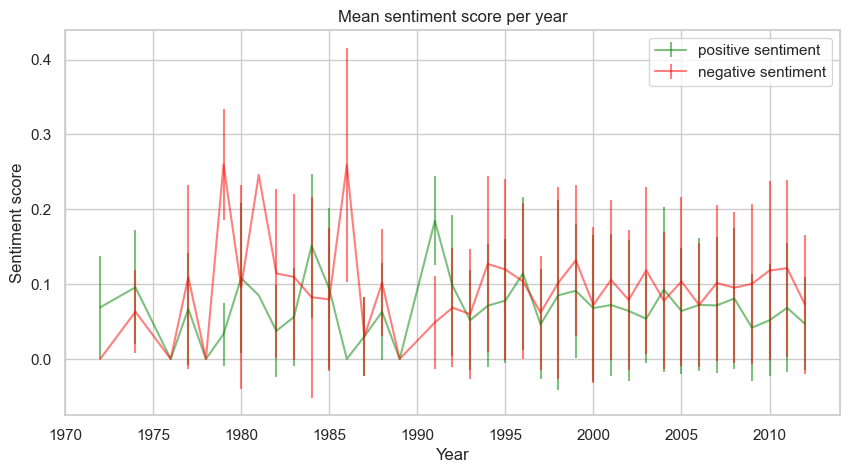

In [2083]:
# lineplot with errorbars of yearly sentiment
plt.figure(figsize=(10,5))
yearly_sentiment = yearly_sentiment[yearly_sentiment['release_date']>=1972]
plt.errorbar(yearly_sentiment['release_date'],yearly_sentiment['pos_sent'].apply(lambda x: np.mean(x)),yerr=yearly_sentiment['pos_sent'].apply(lambda x: np.std(x)),label='positive sentiment',alpha=0.5,color='green')
plt.errorbar(yearly_sentiment['release_date'],yearly_sentiment['neg_sent'].apply(lambda x: np.mean(x)),yerr=yearly_sentiment['neg_sent'].apply(lambda x: np.std(x)),label='negative sentiment',alpha=0.5,color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sentiment score')
plt.title('Mean sentiment score per year')
plt.show()

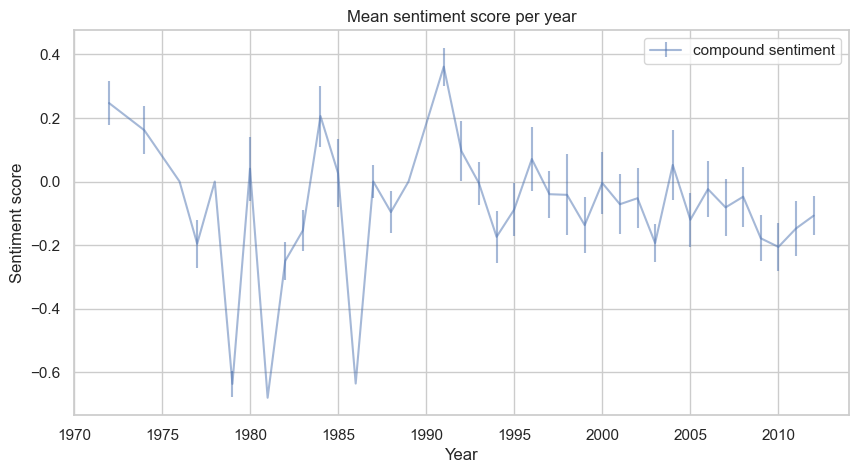

In [2084]:
# lineplot with errorbars of yearly sentiment
plt.figure(figsize=(10,5))
yearly_sentiment = yearly_sentiment[yearly_sentiment['release_date']>=1972]
plt.errorbar(yearly_sentiment['release_date'],yearly_sentiment['comp_sent'].apply(lambda x: np.mean(x)),yerr=yearly_sentiment['pos_sent'].apply(lambda x: np.std(x)),label='compound sentiment',alpha=0.5)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sentiment score')
plt.title('Mean sentiment score per year')
plt.show()

All yearly trends do not have a clear behavior, so we focus on the cumulative plots of the periods 1972-2001 and 2002-2012, similarly to what has been done in the previous parts of the notebook.

In [2085]:
# Perform a t-test to see if the mean compound, negative and positive sentiment are different before and after 2001
print('Compound sentiment:')
print(stats.ttest_ind(yearly_sentiment[yearly_sentiment['release_date']<=2001]['comp_sent'].sum(), yearly_sentiment[yearly_sentiment['release_date']>2001]['comp_sent'].sum()))
print('Positive sentiment:')
print(stats.ttest_ind(yearly_sentiment[yearly_sentiment['release_date']<=2001]['pos_sent'].sum(), yearly_sentiment[yearly_sentiment['release_date']>2001]['pos_sent'].sum()))
print('Negative sentiment:')
print(stats.ttest_ind(yearly_sentiment[yearly_sentiment['release_date']<=2001]['neg_sent'].sum(), yearly_sentiment[yearly_sentiment['release_date']>2001]['neg_sent'].sum()))


Compound sentiment:
TtestResult(statistic=2.0062089097734535, pvalue=0.045015998411511576, df=1477.0)
Positive sentiment:
TtestResult(statistic=2.1753640395428184, pvalue=0.029760991613333704, df=1477.0)
Negative sentiment:
TtestResult(statistic=-0.473441957437635, pvalue=0.6359678669671338, df=1477.0)


In [2086]:
# Number of positive, negative, and neutral local contexts in all the plots
print('Number of positive contexts:',movies_ar_western['pos_sent'].apply(lambda x: sum(np.array(x)>=0.05)).sum())
print('Number of negative contexts:',movies_ar_western['neg_sent'].apply(lambda x: sum(np.array(x)<=0.05)).sum())
print('Number of neutral contexts:',movies_ar_western['neu_sent'].apply(lambda x: sum(np.array(x)<0.05)).sum())

Number of positive contexts: 684
Number of negative contexts: 639
Number of neutral contexts: 25


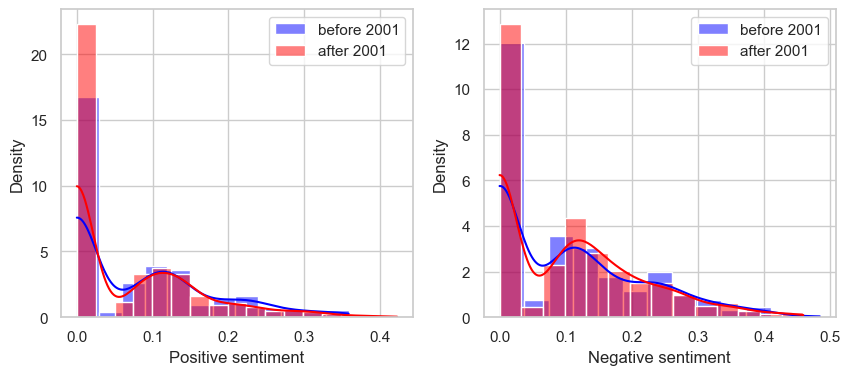

In [2087]:
# Density of positive, negative, and neutral local contexts in all the plots
fig, ax = plt.subplots(1,2,figsize=(10,4))
xlabels = ['Positive sentiment','Negative sentiment']
for i, column in enumerate(['pos_sent','neg_sent']):
    sns.histplot(yearly_sentiment[(yearly_sentiment['release_date']>=1972) & (yearly_sentiment['release_date']<=2001)][column].sum(),label='before 2001',color='blue',alpha=0.5, kde=True, stat='density',ax=ax[i])
    sns.histplot(yearly_sentiment[yearly_sentiment['release_date']>2001][column].sum(),label='after 2001',color='red',alpha=0.5, kde=True, stat='density',ax=ax[i])
    ax[i].legend()
    ax[i].set_xlabel(xlabels[i])
    ax[i].set_ylabel('Density')
plt.show()

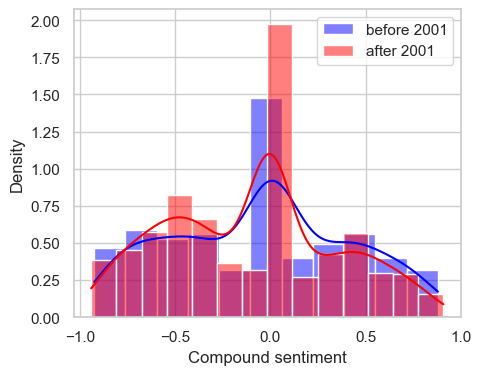

In [2088]:
# Density of compound sentiment in all the plots
plt.figure(figsize=(5,4))
sns.histplot(yearly_sentiment[yearly_sentiment['release_date']<=2001]['comp_sent'].sum(), label='before 2001', color='blue', alpha=0.5, kde=True, stat='density')
sns.histplot(yearly_sentiment[yearly_sentiment['release_date']>2001]['comp_sent'].sum(),label='after 2001',color='red',alpha=0.5, kde=True, stat='density')
plt.xlabel('Compound sentiment')
plt.legend()
plt.show()

In [2089]:
# Count number of entitities per year
print(yearly_sentiment[yearly_sentiment['release_date']<=2001].apply(lambda x: len(x['pos_sent']),axis=1).sum())
print(yearly_sentiment[yearly_sentiment['release_date']>2001].apply(lambda x: len(x['pos_sent']),axis=1).sum())

521
958


The t-test and the plots previously shown show that there is a significant difference in the sentiment between before and after 9/11. The compound plot summarizes these findings, clearly showing how a negative compound score (negative sentiment) is predominantly “after 2001” and a positive compound score (positive sentiment) is mostly “before 2001”.

It is now possible to make a wordcloud plot with the context of arabic names, to visualize the most used words to describe arab characters before and after the year 2001. This visualization is based on the movies that contain an arabic character and that are delivered in "western countries".

In [2090]:
def remove_names(text, arab_names):
    words = text.split()
    p= [word for word in words if word not in arab_names]
    text= " ".join([wl.lemmatize(word) for word in p])
    return text

In [2091]:
# Create a column of chunks of movies_ar_western without arabic characters names
# We also eliminate two common lemmatizations "ha" and "wa" and the word "aladdin" which is a common name in the plots
# because we are not interested in plotting them in the wordcloud
movies_ar_western['chunks_without_arabic_chars'] = movies_ar_western.apply(lambda x: remove_names(x['summary'], x['arabic_chars']+['ha','wa','aladdin']), axis=1)

In [2092]:
# Add to yearly sentiment DataFrame the sum of all plot chunks
yearly_sentiment['total_chunks'] = movies_ar_western['chunks_without_arabic_chars'].groupby(movies_ar_western['release_date'].dt.year).agg('sum').reset_index()['chunks_without_arabic_chars']

In [2093]:
# Apply the preprocessing function to the summaries, to show worclouds
before_2001_text = yearly_sentiment[yearly_sentiment['release_date']<=2001]['total_chunks'].apply(lambda x: preprocess_text(x,list(STOPWORDS)))
after_2001_text = yearly_sentiment[yearly_sentiment['release_date']>2001]['total_chunks'].apply(lambda x: preprocess_text(x,list(STOPWORDS)))
before_2001_text = before_2001_text.apply(lambda x: remove_names(x, ['ha','wa','aladdin']))
after_2001_text = after_2001_text.apply(lambda x: remove_names(x, ['ha','wa','aladdin']))

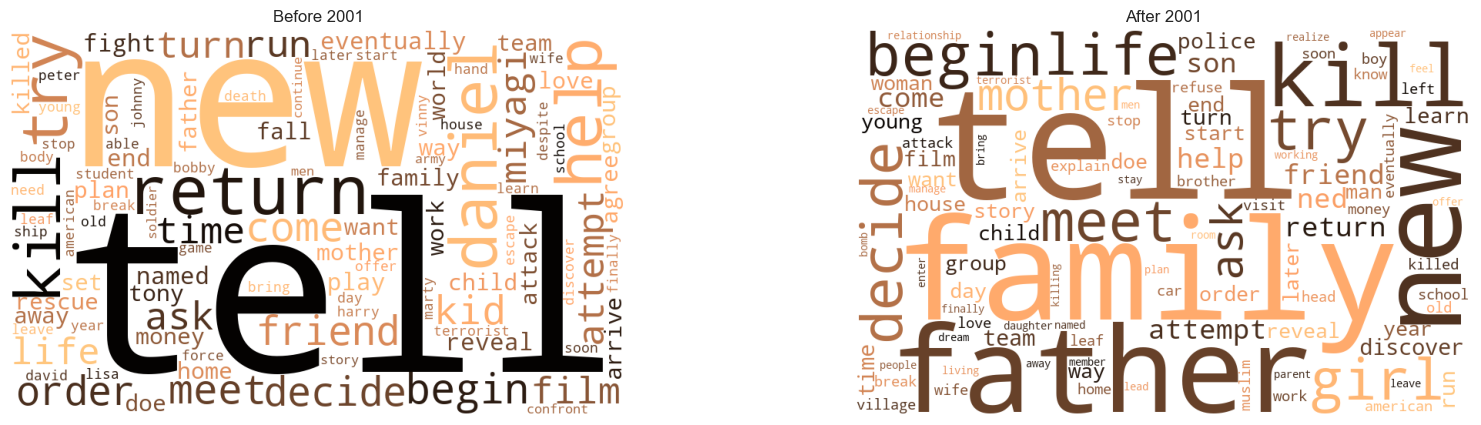

In [2094]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Before 2001')
make_WC_visualization(before_2001_text)

plt.subplot(1,2,2)
plt.title('After 2001')
make_WC_visualization(after_2001_text)

# Topic Modeling

In [2018]:
#get ids of movies with an arabic character in wester movies between 1972 and 2013
arabic_west_ids = set(movies_ar_western['wikiID'])
print(f'We have {len(arabic_west_ids)} movies with an arabic character in its cast')

We have 285 movies with an arabic character in its cast


In [2019]:
#apply the mask to filter out movies with no arabic character
arabic_west_plots = plot_summaries_chars.copy()
arabic_west_plots = arabic_west_plots[arabic_west_plots['wikiID'].isin(arabic_west_ids)]
display(arabic_west_plots)


,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True,[United States of America],1991-10-23,True
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True,"[United States of America, Canada, United King...",2007-09-08,True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Mask, PERSON), (Monique, PERSON), (Jamal, PE...",True,[United States of America],2000-01-01,True
84,1282593,It is spring. Randy Dean is a high school seni...,3620,"[(Randy Dean, PERSON), (only one, CARDINAL), (...","{(Ali, PERSON), (Rubyfruit Jungle, PERSON), (R...",True,[United States of America],1995-01-01,True
108,3662683,"On the morning after his re-election, US Presi...",3101,"[(the morning, TIME), (US, GPE), (Joseph Stato...","{(Martin, PERSON), (Iqbal, PERSON), (Joseph St...",True,[United States of America],2006-04-21,True
...,...,...,...,...,...,...,...,...,...
41714,13177414,"The film is about a young man, Jargo , who is ...",627,"[(Jargo, PERSON), (German, NORP), (Saudi Arabi...","{(Kamil, PERSON), (Jargo, PERSON), (Nora von W...",True,"[Iceland, Germany]",2004-01-01,True
41737,11026100,"In the beginning, the Bratz Kidz , along with ...",6724,"[(the Bratz Kidz, PERSON), (Sasha, GPE), (Ging...","{(Bratz Kidz, PERSON), (Wispings, PERSON), (Ya...",True,[United States of America],2007-01-01,True
41754,67422,Lieutenant Colonel Austin Travis leads an uns...,4918,"[(Austin Travis, PERSON), (Chechen, NORP), (U....","{(Jean-Paul Demou, PERSON), (Jaffa, PERSON), (...",True,[United States of America],1996-03-15,True
41778,1510273,"Chili Palmer helps Edie Athens , the widow of...",3310,"[(Edie Athens, PERSON), (Tommy Athens, PERSON)...","{(Joe Loop, PERSON), (Nick Carr, PERSON), (Lin...",True,[United States of America],2005-03-04,True


In [2020]:
#divide the movies into two categories
arabic_west_plots['release_date'] = pd.to_datetime(arabic_west_plots['release_date'],infer_datetime_format=True)
arabic_west_plots['after 9-11'] = arabic_west_plots['release_date'].apply(lambda x: x> datetime(2002,1,1))
arabic_west_plots
                                                                          

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country,after 9-11
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True,[United States of America],1991-10-23,True,False
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True,"[United States of America, Canada, United King...",2007-09-08,True,True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Mask, PERSON), (Monique, PERSON), (Jamal, PE...",True,[United States of America],2000-01-01,True,False
84,1282593,It is spring. Randy Dean is a high school seni...,3620,"[(Randy Dean, PERSON), (only one, CARDINAL), (...","{(Ali, PERSON), (Rubyfruit Jungle, PERSON), (R...",True,[United States of America],1995-01-01,True,False
108,3662683,"On the morning after his re-election, US Presi...",3101,"[(the morning, TIME), (US, GPE), (Joseph Stato...","{(Martin, PERSON), (Iqbal, PERSON), (Joseph St...",True,[United States of America],2006-04-21,True,True
...,...,...,...,...,...,...,...,...,...,...
41714,13177414,"The film is about a young man, Jargo , who is ...",627,"[(Jargo, PERSON), (German, NORP), (Saudi Arabi...","{(Kamil, PERSON), (Jargo, PERSON), (Nora von W...",True,"[Iceland, Germany]",2004-01-01,True,True
41737,11026100,"In the beginning, the Bratz Kidz , along with ...",6724,"[(the Bratz Kidz, PERSON), (Sasha, GPE), (Ging...","{(Bratz Kidz, PERSON), (Wispings, PERSON), (Ya...",True,[United States of America],2007-01-01,True,True
41754,67422,Lieutenant Colonel Austin Travis leads an uns...,4918,"[(Austin Travis, PERSON), (Chechen, NORP), (U....","{(Jean-Paul Demou, PERSON), (Jaffa, PERSON), (...",True,[United States of America],1996-03-15,True,False
41778,1510273,"Chili Palmer helps Edie Athens , the widow of...",3310,"[(Edie Athens, PERSON), (Tommy Athens, PERSON)...","{(Joe Loop, PERSON), (Nick Carr, PERSON), (Lin...",True,[United States of America],2005-03-04,True,True


In [2021]:
#we get the character names from our plots to filter out for topic modeling as common names may occur
west_chars = [char[0].lower() for sublist in arabic_west_plots['Chars in plot'] for char in sublist]
west_chars= set(west_chars)


In [2022]:
#we are going to use a list of stop words for the lda extended to character names and punctuation
lda_stopwords = list(STOPWORDS)
lda_stopwords.extend(west_chars)
lda_stopwords.extend(['plot','film','movie'])
lda_stopwords.extend(list(string.punctuation))
len(lda_stopwords)

2488

In [2023]:
#apply preprocessing to the plots at hand
arabic_west_plots['summary']=arabic_west_plots['summary'].apply(lambda x: preprocess_text(x,lda_stopwords))
arabic_west_plots.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country,after 9-11
14,1480747,following sudden death father local church don...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True,[United States of America],1991-10-23,True,False
42,5425205,khitrova midwife london find diary body girl d...,3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True,"[United States of America, Canada, United King...",2007-09-08,True,True
59,15161056,begin boy named hots beautiful girl named reje...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Mask, PERSON), (Monique, PERSON), (Jamal, PE...",True,[United States of America],2000-01-01,True,False
84,1282593,high school senior poor school friend secret c...,3620,"[(Randy Dean, PERSON), (only one, CARDINAL), (...","{(Ali, PERSON), (Rubyfruit Jungle, PERSON), (R...",True,[United States of America],1995-01-01,True,False
108,3662683,morning president staton decides read newspape...,3101,"[(the morning, TIME), (US, GPE), (Joseph Stato...","{(Martin, PERSON), (Iqbal, PERSON), (Joseph St...",True,[United States of America],2006-04-21,True,True


In [2024]:
#arabic movies before 2001
arabic_pre_2001 =arabic_west_plots.copy()
arabic_pre_2001 = arabic_pre_2001[arabic_pre_2001['after 9-11']==False]
arabic_pre_2001 

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country,after 9-11
14,1480747,following sudden death father local church don...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Zora knocks, PERSON), (Miles, PERSON), (Dean...",True,[United States of America],1991-10-23,True,False
59,15161056,begin boy named hots beautiful girl named reje...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Mask, PERSON), (Monique, PERSON), (Jamal, PE...",True,[United States of America],2000-01-01,True,False
84,1282593,high school senior poor school friend secret c...,3620,"[(Randy Dean, PERSON), (only one, CARDINAL), (...","{(Ali, PERSON), (Rubyfruit Jungle, PERSON), (R...",True,[United States of America],1995-01-01,True,False
663,3136201,italian dictator benito faced long war waged p...,1975,"[(1929, DATE), (Italian, NORP), (Benito Mussol...","{(Rodolfo Graziani, PERSON), (Mukhtar, PERSON)...",True,"[United States of America, Libya]",1981-04-17,True,False
884,2617386,littlefoot notice longneck herd entering great...,3430,"[(Great Valley, LOC), (The Land of Mists, WORK...","{(Ichy, PERSON), (Ali, PERSON), (Cera, PERSON)...",True,[United States of America],1996-12-10,True,False
...,...,...,...,...,...,...,...,...,...,...
40958,223268,tenenbaum explaining scene evolves short expla...,3922,"[(Royal Tenenbaum, PERSON), (three, CARDINAL),...","{(Royal Tenenbaum, PERSON), (Etheline, PERSON)...",True,[United States of America],2001-10-05,True,False
40993,4343453,year old teen decides throw slumber party pare...,3064,"[(Trish Devereaux, PERSON), (18 year old, DATE...","{(Coach Jana, PERSON), (Russ, PERSON), (Linda,...",True,[United States of America],1982-01-01,True,False
41190,490101,agent fails routine training order bond enrol ...,3286,"[(MI6, PERSON), (James Bond, PERSON), (007, CA...","{(Fatima Blush, PERSON), (Ernst Stavro Blofeld...",True,"[United States of America, United Kingdom, Ger...",1983-01-01,True,False
41463,2885391,itn reporter henderson travel besieged capital...,3612,"[(1992, DATE), (ITN, ORG), (Michael Henderson,...","{(Sarajevan, PERSON), (Risto, PERSON), (Saraje...",True,"[United States of America, United Kingdom]",1997-05-09,True,False


In [2025]:
#arabic movies after 2001
arabic_post_2001 =arabic_west_plots.copy()
arabic_post_2001 = arabic_post_2001[arabic_post_2001['after 9-11']==True]

arabic_post_2001 

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country,after 9-11
42,5425205,khitrova midwife london find diary body girl d...,3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Nikolai Luzhin, PERSON), (Kirill, PERSON), (...",True,"[United States of America, Canada, United King...",2007-09-08,True,True
108,3662683,morning president staton decides read newspape...,3101,"[(the morning, TIME), (US, GPE), (Joseph Stato...","{(Martin, PERSON), (Iqbal, PERSON), (Joseph St...",True,[United States of America],2006-04-21,True,True
364,30714098,arrives spain san francisco holiday picked wor...,4437,"[(Will Shaw, PERSON), (Spain, GPE), (San Franc...","{(Martin, PERSON), (Will, PERSON), (Zahir, PER...",True,[United States of America],2012-04-06,True,True
495,27923824,occurs home rey leaving infant son bedroom thi...,3650,"[(2006, DATE), (Kristi, PERSON), (Dan Rey, PER...","{(Martine, PERSON), (Dan Rey, PERSON), (Ali, P...",True,[United States of America],2010-10-20,True,True
692,5875034,opening scene explains origin diplomatic relat...,7597,"[(U.S.-Saudi, ORG), (the Middle East, LOC), (t...","{(al-Ghazi, PERSON), (Schmidt, PERSON), (Ahmed...",True,"[United States of America, Germany]",2007-08-22,True,True
...,...,...,...,...,...,...,...,...,...,...
41557,11347793,begin airport marjane satrapi unable board pla...,8271,"[(Paris-Orly Airport, ORG), (Marjane Satrapi, ...","{(Shah, PERSON), (Taji, PERSON), (Marji, PERSO...",True,"[France, United States of America]",2007-06-27,True,True
41714,13177414,young german descent resided saudi arabia fath...,627,"[(Jargo, PERSON), (German, NORP), (Saudi Arabi...","{(Kamil, PERSON), (Jargo, PERSON), (Nora von W...",True,"[Iceland, Germany]",2004-01-01,True,True
41737,11026100,kidz new set sleeping bag explains sleepover s...,6724,"[(the Bratz Kidz, PERSON), (Sasha, GPE), (Ging...","{(Bratz Kidz, PERSON), (Wispings, PERSON), (Ya...",True,[United States of America],2007-01-01,True,True
41778,1510273,palmer help athens widow executed athens resur...,3310,"[(Edie Athens, PERSON), (Tommy Athens, PERSON)...","{(Joe Loop, PERSON), (Nick Carr, PERSON), (Lin...",True,[United States of America],2005-03-04,True,True


In [2026]:
#Implementation of the LDA Model for before 2001 movies
texts_gen = [doc.split() for doc in arabic_pre_2001['summary']]
dictionary_gen = corpora.Dictionary(texts_gen)
corpus_gen = [dictionary_gen.doc2bow(text) for text in texts_gen]

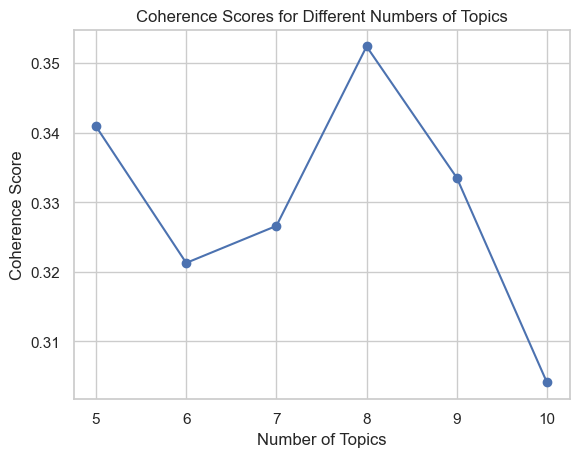

In [2027]:
# Specify the range of topic numbers to try
min_topics = 5
max_topics = 10
step_size = 1

topic_range = range(min_topics, max_topics + step_size, step_size)

# Initialize lists to store coherence scores
coherence_scores = []

# Iterate over different numbers of topics
for num_topics in topic_range:
    lda_gen = LdaMulticore(corpus=corpus_gen, id2word=dictionary_gen, num_topics=num_topics, passes=100,random_state=1000)

    # Evaluate coherence
    coherence_model = CoherenceModel(
        model=lda_gen,
        texts=texts_gen,
        dictionary=dictionary_gen,
        coherence='c_v'
    )
    
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot the elbow curve
plt.plot(topic_range, coherence_scores, marker='o')
plt.title('Coherence Scores for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()


Based on the above plot, it seems like the best value for our hyparameter to use on the lda model is 8 number of topics as it has a peak in the coherence value. Based on this metric, and the human intepretability of the tops words for each topic provided by the model we decide to use this value as our number of topics for both corpuses (before and after 2001)

In [2040]:
# LDA Model
num_topics = 8
lda_gen = LdaMulticore(corpus=corpus_gen, id2word=dictionary_gen, num_topics=num_topics, passes=100,random_state = 1000)

# Evaluate coherence
coherence_model = CoherenceModel(
    model=lda_gen,
    texts=texts_gen,
    dictionary=dictionary_gen,
    coherence='c_v'
)
print(f"Coherence Score: {coherence_model.get_coherence()}")

Coherence Score: 0.3524100551977908


In [2041]:
# Prepare data for visualization
data_before = pyLDAvis.gensim_models.prepare(lda_gen, corpus_gen, dictionary_gen)
# Display the modified data
pyLDAvis.display(data_before)

In [2042]:
# Save the visualization to html
pyLDAvis.save_html(data_before, 'lda_before.html')

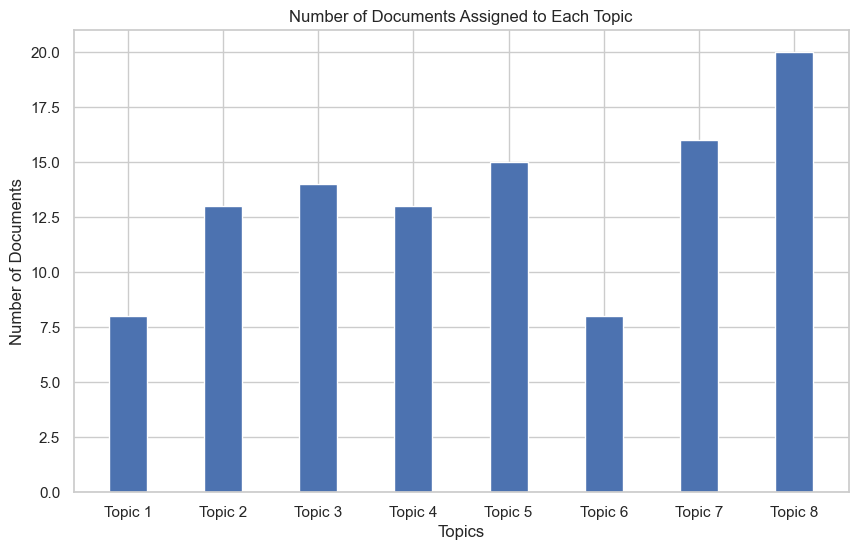

In [2043]:
# Get the topic distributions for each document in the corpus
topic_distributions = lda_gen.get_document_topics(corpus_gen, per_word_topics=False)

# Extract the most probable topic for each document
most_probable_topics = [max(doc, key=lambda x: x[1])[0] for doc in topic_distributions]

# Count the occurrences of each topic
topic_counts = Counter(most_probable_topics)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.4

# Set the positions for the topics
topic_positions = np.arange(lda_gen.num_topics)

# Plot bars for each topic
ax.bar(topic_positions, [topic_counts.get(topic, 0) for topic in range(lda_gen.num_topics)], bar_width)

# Set labels and title
ax.set_xlabel('Topics')
ax.set_ylabel('Number of Documents')
ax.set_title('Number of Documents Assigned to Each Topic')
ax.set_xticks(topic_positions)
ax.set_xticklabels([f'Topic {i + 1}' for i in range(lda_gen.num_topics)])

plt.show()


This visualization highlights the seperation of topics by the model which indicates that the topics are not overlapping and is coherent. This observation implies that the chosen number of topics is well-optimized for our corpus of movies containing an arabic character before 2001, specifically comprising movies with Arabic characters.

When looking at the classification of the documents in our corpus into the different topics we can see most documents are classified under topic 8, 7, and 5 (in descending order for number of documents) Analyzing the 30 most frequent words in topic 4, we observe terms such as "fight," "kill," "terrorist," "hostage," and "force". This shows that the topic of these movies have a negative sentiment. It is also worth noting that these words have a high overall term frequency with respect to the corpus as we can see in the interactive plot

Next we will do the same analysis on movies after 9-11

In [2044]:
#Implementation of the LDA Model for after 2001 movies
texts = [doc.split() for doc in arabic_post_2001['summary']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA Model
num_topics = 8
lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=100,random_state = 11)

# Evaluate coherence
coherence_model = CoherenceModel(
    model=lda,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)
print(f"Coherence Score: {coherence_model.get_coherence()}")

Coherence Score: 0.34008578455161204


In [2045]:
# Prepare data for visualization
data_after = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
# Display the modified data
pyLDAvis.display(data_after)

In [2050]:
# Save the visualization to html
pyLDAvis.save_html(data_after, 'lda_after.html')

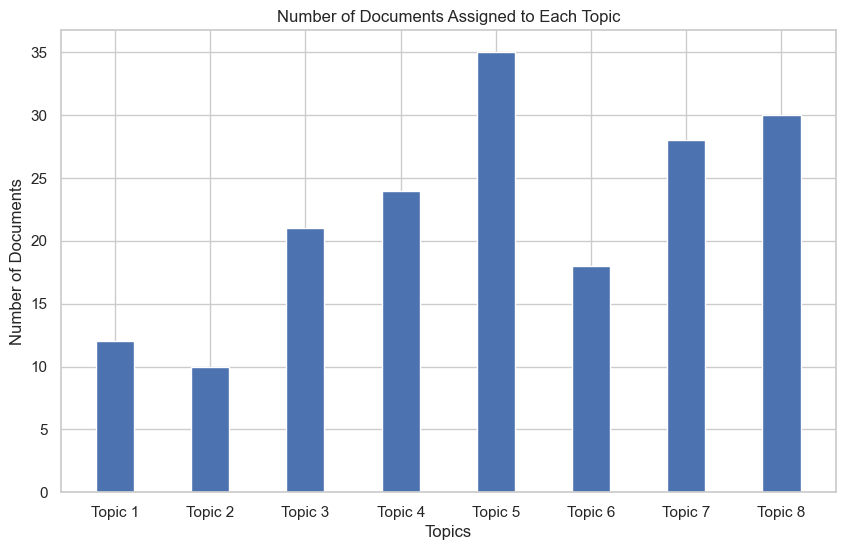

In [2047]:
# Get the topic distributions for each document in the corpus
topic_distributions = lda.get_document_topics(corpus, per_word_topics=False)

# Extract the most probable topic for each document
most_probable_topics = [max(doc, key=lambda x: x[1])[0] for doc in topic_distributions]

# Count the occurrences of each topic
topic_counts = Counter(most_probable_topics)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.4

# Set the positions for the topics
topic_positions = np.arange(lda.num_topics)

# Plot bars for each topic
ax.bar(topic_positions, [topic_counts.get(topic, 0) for topic in range(lda.num_topics)], bar_width)

# Set labels and title
ax.set_xlabel('Topics')
ax.set_ylabel('Number of Documents')
ax.set_title('Number of Documents Assigned to Each Topic')
ax.set_xticks(topic_positions)
ax.set_xticklabels([f'Topic {i + 1}' for i in range(lda.num_topics)])

plt.show()


We see from the bar plot that most documents (35) after 2001 are classified in the 5th topic. Analyzing the 30 most frequent words of topic 1 (the most predominant), the only observed bad terms are "police," "kill,", "police". Analyzing also the most common words for topic 2 (the 2nd most predominant topic) we can see word that refer that may lead us to think of the 9-11 event for example "flight","place" ,"bomb","terrorist","american". The plotted data further indicates a high overall term frequency for words such as "kill," "terrorist," and "police." This elevated frequency suggests a notable importance on these terms within the corpus.

We can then conclude that visibly it seems like in general, movies with arabic characters have topics associated with bad words like kill, bomb, terrorism, attack, police but we cannot really conclude if there is a shift in 2001 after the event since both models containg the same words with approximotly the same overall term frequency with respect to their corpus